# Thorough Testing of Internal Reference Scaling (IRS)

## Phillip Wilmarth, OHSU

### January 5, 2019

---

## What and Why

#### This notebook will:

- give a brief overview of Internal Reference Scaling
  - why we need IRS and what IRS corrects
  - IRS algorithm specifics
  - IRS experimental design using reference channels
- show that 4 commonly used normalization methods do not work

#### You will learn:

- normalization between TMT plexes is fundamentally different
- MS2 sampling effect has to be removed
- working with data in natural scales has major benefits
  
## What is IRS?

### The problem

If we label the same sample in more than one channel in an isobaric labeling experiment (one labeling kit of samples will be called a "plex" to avoid confusion with "run" or "experiment") and perform some very basic data normalizations, we will see that the measurement values for those channels at any level (PSM, peptide, or protein) are very nearly identical. We can aggregate (sum) the data (intensities or peak heights) from the individual PSMs into peptide totals or into protein totals (based on protein inference rules). It does not matter if the single plex was analyzed using a single LC run or multiple LC runs (fractions). Data quality improves as a function of aggregation with protein level data having lower variation than peptide or PSM data ([see this notebook](https://pwilmart.github.io/TMT_analysis_examples/MAN1353_peptides_proteins.html)). Different channels of the same sample (technical replicates) can be used to verify that data aggregation steps do not distort the inherent realtive precision of isobaric measurements between channels in a single plex.

What happens when we have the same samples in different plexes? Even with 11 channels currently avaialble, more channels may be needed to accommodate all of the biological samples and more than one isobaric plex will need to be used. If we do basic single factor normalizations (matching median intensities or total intensities), we will find that we **do not** get similar intensity measurements of the same thing between plexes. The overall intensity of reporter ions depends not only on the abundance of the peptide, but on when the peptide was "sampled". The fragmentation scans that provide the peptide sequence and the reporter ion signals (this can be a single scan or a pair of linked scans) are a few 10s to 100s of milliseconds in duration. The extracted ion chromatograms (XIC) of peptides are most often 10s of seconds (30 seconds to 1 minute are typical). If the fragmentation scan occurs at the apex of the XIC, the report ions will be more intense that from fragmentation scans taken at other points along the XIC (such as near the baseline).

![XIC diagram](https://pwilmart.github.io/TMT_analysis_examples/xic.png)

### Isobaric labeling

Isobaric labeling (**[Ref-1](#ref1), [Ref-2](#ref2)**) is a precise relative quantification method because reporter ion intensities are simultaneously measured in a single instrument scan. (Isobaric tag and TMT will be used interchangeably.) Shotgun proteomics works by chopping proteins into large numbers of peptides that can be separated by liquid chromatography and sequenced by mass spectrometers. The overwhelmingly large number of measurements from all of the small pieces is far less useful than aggregating the data from the pieces (the peptides) back into the whole (the proteins). 

The relative precision of the reporter ions is maintained when the data from the pieces are summed together. The intensities of the pieces will vary depending on many factors such as analyte abundance, and when the analyte is sampled during its elution profile. Isobaric labeling reporter ions come from MS2 "snapshots" of the eluting peptide. MS2 scan selection in shotgun proteomics is kind of a random process (**[Ref-3](#ref3)**) given the sample complexity. MS2 scans are not like integrated MS1 peak heights or areas, which tend to be more stable values. MS2 scans taken from the leading or trailing edge near the baseline will be less intense than MS2 scans taken near the chromatography peak apex. The intensities of ions in MS2 scans (including the reporter ions) are highly variable.

Within a single TMT plex (one set of isobaric labeling tags, a.k.a. one kit), the random nature of MS2 scan selection can be pretty safely ignored. Pretty much any way that data can be analyzed ends up working okay because of the relative precision of the reporter ions within each scan. The situation **changes dramatically** when data from more than one TMT plex is combined in larger experiments. Now the intensity differences that depend on when the MS2 scans were selected in each TMT experiment will dramatically alter the scales of the intensity values, and the data cannot be combined until these differences are removed. 

### Need for reference channels

Ironically, in much the same way that the **similarities** between reporter ions within the same scan are retained during data aggregations for a single TMT plex, the **differences** between reporter ions from different MS2 scans persists after data aggregations and conventional normalization methods. A specific algorithm to determine and correct the MS2 sampling effect has to be used. 

Adding a common reference channel to each plex has been done in isobaric labeling for many years. The reference channel has mostly been used as a common denominator in ratios with each biological sample. This has the desired effect of normalizing the ratios to a common scale. The downside is that ratios are not very intuitive, have compressed dynamic range, have half of the values between 0 and 1.0 and the other half between 1.0 and infinity, and are not tolerant of zero values (missing data). Because of that asymmetry, logarithms are often necessary, and those further compress the dynamic range of the measurements are even less intuitive that ratios.

Another drawback with ratios is that they are like the edges in a network. Their number grows much more rapidly that the number of network nodes. In an isobaric labeling study with a single common channel, there is no ambiguity in taking ratios of each channel to the reference. There is only one way to do that. If you have half of the channels as controls and half as treatments, then there is ambiguity about what ratios to form to compare control to treatment. If you have 2 channels (one of each condition), there is one ratio. If you have 2 of each condition, there are 4 different ratios. If you have 3 of each condition, there are 9 ratios. The number of ratios is the product of the number of samples in each condition. 10-plex TMT could accommodate 5 of each condition and result in 25 ways to take ratios. Statistically (mathematically) this is not good. It is an over-determined problem where there are more ratios than degrees of freedom.

### IRS method maintains the natural measurement scale

Is there another way to make use of reference channels to put reporter ion intensities on a common scale that does not involve ratios? In protein expression studies using TMT, a large number of PSM data points will aggregate into a much more manageable and shorter list of proteins. The reference channels, being the same in each TMT plex are like yardsticks (or meter sticks) that measure an observed value for each protein in each plex. The main assumption of IRS is that those **numbers should have been the same** since the **reference channel was the same**. The measured values are not identical in each plex (mostly) because of random MS2 scan selection. We can mathematically make them all the same between the plexes using scaling factors for each protein, as shown in the diagram below.

![IRS Method](https://pwilmart.github.io/TMT_analysis_examples/irs_diagram.png)

Since the non-reference channel(s) in each single plex have high relative precision that is independent of the magnitude of the intensity values, we can scale all of these other channels by the same scale factors that we are using on the reference channels. This adjusts **all channels** in each TMT plex on to a common intensity scale. This method is called internal reference scaling (IRS) and was first described in (**[Ref-4](#ref4)**). After IRS, any channel can be directly compared to any other channel (within TMT plex and between TMT plexes become equivalent). Importantly, the data used for the scaling factors are independent of the data used in statistical testing.

It is time for a conceptual description of IRS using [jazz hands](https://en.wikipedia.org/wiki/Jazz_hands). Think of each plex's channels as the fingers on a hand. If we have an experiment with two plexes, that is like our two hands. Because of pseudo random MS2 sampling we have different overall intensity scales. This is like our two hands being at different heights. The IRS method measures the heights of the hands and determines how much to move one hand down and the other hand up to bring them into alignment. The fingers (hopefully) all move with the hands, so when the hands are in alignment, then all of the fingers are also in alignment. That is all that there is to IRS. Really. 

The IRS experimental design outlined in (**[Ref-4](#ref4)**) was to use duplicate channels of the same pooled internal standard in each TMT plex. With only 10 or 11 channels per plex available, this might seem excessive. However, there are several quality control and accuracy arguments to support two channels instead of just one. The average of two measurements will be much better than just one, and everything hangs on the accuracy of the scaling factors. It is possible (but hopefully rare) to accidently mis-label samples and it may not be clear which channels where the standards. The strong similarity of the two duplicate standard channels can be used to find them in the presence of the biological samples, which are not usually as similar to each other (see [this notebook](https://pwilmart.github.io/TMT_analysis_examples/auto_finder_PAW.html)).  

### Testing and validating IRS

Validation of IRS was done in the Supplemental materials of **[Ref-4](#ref4)** by using half of the pooled standards for IRS and using the other half as a validation set. A recently completed experiment used seven 11-plex TMT labelings to study exosomes from 3 groups with 20 biological samples each. Each 11-plex TMT experiment used duplicated pooled standard channels. That allowed 9 channels for biological samples per plex. Seven plexes would have 63 available channels. After the 60 biological samples, that left 3 additional channels. Extra pooled standard samples were labeled and analyzed in the three extra channels. Those 3 extra channels were distributed in three of the 7 TMT experiments.

This allows a rigorous independent validation of the IRS method. There are three TMT experiments with triplicate pooled standards run in the same TMT experiment. We also have the three extra pooled standards in different TMT plexes that can be compared before and after a proper IRS normalization based on pairs of pooled standards. Remember that the master pooled standard protein mixture is created from equal amounts of all 60 samples and each pooled standard channel is an independent digestion and labeling of an aliquot of the master pooled standard protein mixture.

### Data description

The data are from human urine exosomes from the Christina Binder lab at OHSU. Exosome isolation was performed at Ymir Genomics (Boston, MA) by Shannon Pendergrast. eFASP digestion (**[Ref-5](#ref5)**), 11-plex TMT labeling (Thermo Fisher Scientific), liquid chromatography, and mass spectrometry analysis was performed at OHSU by Ashok Reddy. The IRS experimental study design was used to accommodate 20 samples per condition in 7 TMT plexes. 30-fraction online high pH RP/low pH RP LC separations were done. The SPS MS3 method (**[Ref-6](#ref6)**) was used on a Thermo Fusion with the manufacturer's default method. 

Data analysis was performed by Phil Wilmarth, OHSU. RAW files were converted to text files using MSConvert (**[Ref-7](#ref7)**). [Python scripts](https://github.com/pwilmart/PAW_pipeline.git) created MS2 spectra for database searching and tables of the reporter ion intensities (peak heights) for each MS3 scan. Comet database searches (**[Ref-8](#ref8)**) were performed using a canonical protein database (downloaded with software available [here](https://github.com/pwilmart/fasta_utilities.git)), tryptic cleavage, a wider parent ion mass tolerance search, static TMT label modifications, and variable oxidation of methionine. An extended version of the PAW pipeline (**[Ref-9](#ref9)**) was used for filtering of PSM identifications by accurate masses and by the target/decoy strategy (**[Ref-10](#ref10)**) to obtain 1% PSM FDR. Parsimony (**[Ref-11](#ref11)**) and [extended parsimony](https://digitalcommons.ohsu.edu/etd/3855/) analyses were used to produce a final list of identified proteins and to determine which peptides were unique to the final protein groups. Total protein intensities were computed as the sums of all unique peptide reporter ion signals (**[Ref-12](#ref12)**). IRS normalization of the TMT data across the 7 TMT experiments was done using [Python scripts](https://github.com/pwilmart/PAW_pipeline.git). The analysis presented here was performed with a [Jupyter notebook](https://jupyter.org/) and an R kernel. 

### References

<a id=ref1></a>
> **Ref-1.** Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

<a id=ref2></a>
> **Ref-2.** Ross, P.L., Huang, Y.N., Marchese, J.N., Williamson, B., Parker, K., Hattan, S., Khainovski, N., Pillai, S., Dey, S., Daniels, S. and Purkayastha, S., 2004. Multiplexed protein quantitation in Saccharomyces cerevisiae using amine-reactive isobaric tagging reagents. Molecular & cellular proteomics, 3(12), pp.1154-1169.

<a id=ref3></a>
> **Ref-3.** Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

<a id=ref4></a>
> **Ref-4** Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of TMT labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

<a id=ref5></a>
> **Ref-5** Erde, J., Loo, R.R.O. and Loo, J.A., 2014. Enhanced FASP (eFASP) to increase proteome coverage and sample recovery for quantitative proteomic experiments. Journal of proteome research, 13(4), pp.1885-1895.

<a id=ref6></a>
> **Ref-6** McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

<a id=ref7></a>
> **Ref-7** Kessner, D., Chambers, M., Burke, R., Agus, D. and Mallick, P., 2008. ProteoWizard: open source software for rapid proteomics tools development. Bioinformatics, 24(21), pp.2534-2536.

<a id=ref8></a>
> **Ref-8** Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

<a id=ref9></a>
> **Ref-9** Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

<a id=ref10></a>
> **Ref-10** Elias, J.E. and Gygi, S.P., 2007. Target-decoy search strategy for increased confidence in large-scale protein identifications by mass spectrometry. Nature methods, 4(3), p.207.

<a id=ref11></a>
> **Ref-11** Nesvizhskii, A.I. and Aebersold, R., 2005. Interpretation of shotgun proteomic data the protein inference problem. Molecular & cellular proteomics, 4(10), pp.1419-1440.

<a id=ref12></a>
> **Ref-12** Wenger, C.D., Phanstiel, D.H., Lee, M.V., Bailey, D.J. and Coon, J.J., 2011. COMPASS: A suite of pre‐and post‐search proteomics software tools for OMSSA. Proteomics, 11(6), pp.1064-1074.

## Load libraries

In [1]:
# library imports
library(tidyverse) # ggplot2 and much more
library(psych) # scatter plot panels
library(edgeR) # TMM normalization
library(robustbase) # column medians
library(preprocessCore) # from Bioconductor - quantile normalization

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.0     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

Warning message:
“package ‘edgeR’ was built under R version 3.5.2”Loading required package: limma
Warning message:
“package ‘limma’ was built under R version 3.5.1”
Attaching package: ‘robustbase’

The following object is masked from ‘package:psych’:

    cushny

Warning message:
“package ‘preprocessCore’ was built under R version 3.5.1”

## Load the TMT data
The PAW pipeline has a Python script that does IRS normalizations between plexes from the main protein and peptide results summary files. It takes care of normalizing with each TMT plex, globally between plexes, and then uses the designated reference channels to calculate the IRS factors. We will read in that tab-delimited file.

It has the raw reporter ion data, the globally scaled reporter ion data (called sample loading normalized data), and the IRS normalized data. Columns are labeled by plexes, by normalization, and by sample keys. We have already done some QC and [double checked](auto_finder_BIND-473.ipynb) that the pooled internal reference channels were 131-N and 131-C tags in each plex. The IRS script looks for sample names with "pool" in them to find the reference channels. In this 77-channel experiment, we have a third standard sample in the 130-C channel in experiments 2, 4, and 6. The IRS method is using the 131-N and 131-C standards. This leaves the 130-C standards as independent channels to validate the IRS method.

In [2]:
# load the PAW data file (from IRS script) and check the dta frame
# read_tsv is more picky about column types - increase the "guess" range
data_import <- read_tsv("pooled_grouped_protein_summary_TMT_IRS_normalized.txt",
                       guess_max = 3675)

# get the non-contaminant proteins seen in all 7 plexes (2152 proteins)
# the prepped table from pandas is sorted so these are the upper rows
data_intersect <- filter(data_import, is.na(Filter), is.na(Missing))
nrow(data_import)
nrow(data_intersect)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] 3675

[1] 2152

### Data has been read in okay
These data frame reading routines (read_tsv, etc.) always do a lot of automated data parsing to "help" you out. Sometimes it is great, sometimes it is not. It is important to make sure you are getting what you expect. The IRS script told us that there were 2152 proteins seen in all 7 of the plexes. We should have that number of rows after filtering, and we do.

## Get the three reference columns from experiments 2, 4, and 6
To keep things simpler, we will focus on the three plexes where we have three reference channels. In triplicate, we have 3 references from within a single plex to see what the channel-to-channel similarity is like. We can contrast that with the 3 extra reference channels that are in three different plexes.

The first thing is to get the relevant data. We will get the un-normalized data (a.k.a. "raw"). We will make a data frame for each of the three experiments (2, 4, and 6) and each frame will have 3 columns (the extra and the two IRS reference channels). We will combine those after we extracted the reference channels from each plex.

In [3]:
# we will be most interested in the 3 plexes with 3 reference channels
# those are experiments 2, 4, and 6
exp2_raw <- data_intersect %>% 
  select(matches("TotInt_.*_Exp2")) %>%
  select(contains("_130C_"), contains("_131"))

exp4_raw <- data_intersect %>% 
  select(matches("TotInt_.*_Exp4")) %>%
  select(contains("_130C_"), contains("_131"))

exp6_raw <- data_intersect %>% 
  select(matches("TotInt_.*_Exp6")) %>%
  select(contains("_130C_"), contains("_131"))

# each data frame is 3 columns (9, 10, and 11 channels of each plex)

### How similar are the data from the 3 plexes?
How do we check if our data needs normalization and evaluate if the normalization has worked? Many normalization methods adjust some aspect of the data distributions to make them more similar. Therefore, computing distribution summary numbers and visualizing distributions will be needed. We will be doing this several times, so we will make a function.

**Function steps:**
- compute and print column totals
- compute and print median intensities and IQR (interquartile range)
- make distribution boxplots (colored by exp)
- compute CV distributions
  - probes behavior of each protein
  - compute and print median CVs and IQRs
  - make distribution boxplots


Column Summaries (raw data):
  TotInt_130C_Exp2 - tot: 1,960,333,996 med: 110,104 iqr: 371,355
  TotInt_131N_Exp2 - tot: 1,839,411,554 med: 105,074 iqr: 351,433
  TotInt_131C_Exp2 - tot: 1,826,650,885 med: 104,814 iqr: 354,742
  TotInt_130C_Exp4 - tot: 1,330,669,102 med: 81,571 iqr: 248,739
  TotInt_131N_Exp4 - tot: 1,237,179,672 med: 77,382 iqr: 228,845
  TotInt_131C_Exp4 - tot: 1,111,150,604 med: 68,496 iqr: 204,376
  TotInt_130C_Exp6 - tot: 1,180,655,739 med: 60,404 iqr: 216,738
  TotInt_131N_Exp6 - tot: 1,219,129,046 med: 64,132 iqr: 227,358
  TotInt_131C_Exp6 - tot: 1,319,485,897 med: 70,959 iqr: 247,425

Median CVs (raw data):
  exp2_CV - med: 5.53 iqr: 4.63
  exp4_CV - med: 10.13 iqr: 5.21
  exp6_CV - med: 8.56 iqr: 5.26


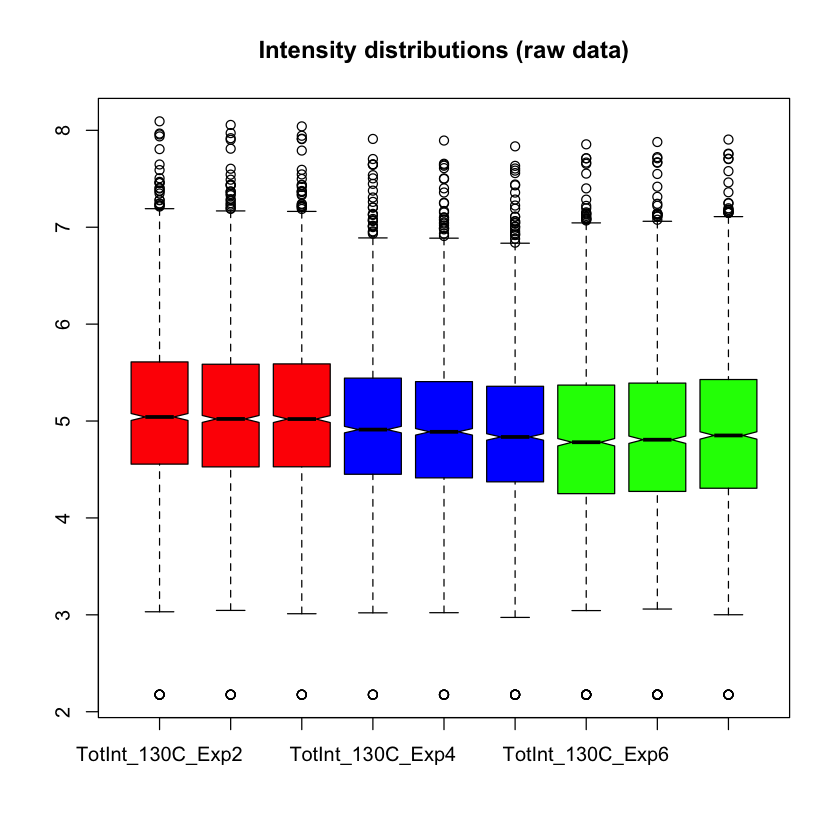

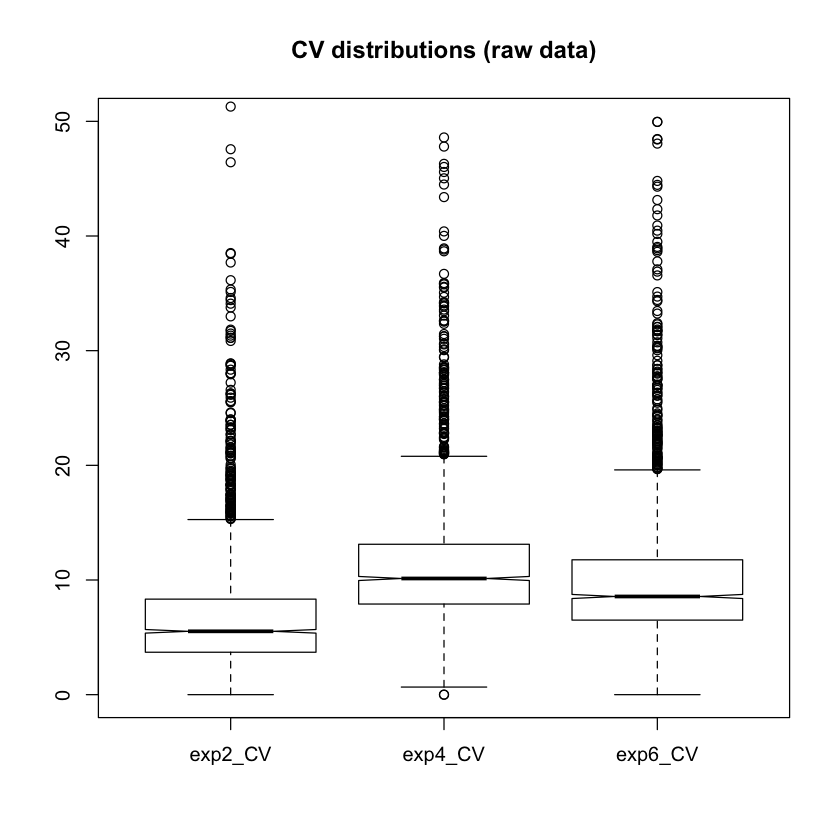

In [4]:
# make a data summary function for some data printouts and data visualizations
# helper CV functions
CV <- function(df) {
    # Computes and returns a vecotr of CV values
        # df - data frame: CV computed per row
    
    ave <- rowMeans(df) # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave # compute CVs in percent (last thing gets returned)
}

check_data <- function(df, title) {
    # Checks data normalizations with distribution summaries and plots
        # df - data frame (expects 3x3 or 3 for this notebook)
        # title - some text to use in print statements and plot labels

    # get some summary numbers: column totals and medians
    cat(sprintf("\nColumn Summaries (%s):\n", title))
    for (i in 1:ncol(df)) {
        cat(sprintf("  %s - tot: %s med: %s iqr: %s\n", colnames(df)[i],
                format(round(sum(pull(df[i])), digits = 0), big.mark = ','),
                format(round(median(pull(df[i])), digits = 0), big.mark = ','),
                format(round(IQR(pull(df[i])), digits = 0), big.mark = ',')))
    }    
    # see what the data distribution boxplot look like
    boxplot(log10(df), 
            col = c(rep(c("red", "blue", "green"), each = 3)), 
            notch = TRUE, main = sprintf("Intensity distributions (%s)", title))
        
    # CV distributions
    if (ncol(df) == 9) {
        CVs <- data.frame(exp2_CV = CV(df[1:3]), exp4_CV = CV(df[4:6]), exp6_CV = CV(df[7:9]))
        ymax = 50
    } else {
        CVs <- data.frame(Extras = CV(df[1:3]))
        ymax = 100
    }
    # print values
    cat(sprintf("\nMedian CVs (%s):\n", title))
    for (i in 1:ncol(CVs)) {
        cat(sprintf("  %s - med: %s iqr: %s\n", colnames(CVs)[i],
                round(median(pull(CVs[i])), digits = 2),
                round(IQR(pull(CVs[i])), digits = 2)))
    }
    # show boxplots
    boxplot(CVs, ylim = c(0, ymax), notch = TRUE, main = sprintf("CV distributions (%s)", title))
}

# put the 3 experiment in one data frame and check the data
all_raw <- data.frame(exp2_raw, exp4_raw, exp6_raw)
check_data(all_raw, "raw data")    

### There are some systematic differences between plexes
The total intensities and median intensities from experiment 2 are higher than the other two. There are also some differences between channels, particularly for experiments 4 and 6. The centers of the boxes (the median intensities) are not horizontally aligned. There are also some differences in the sizes of the boxes (the interquartile ranges). The median CV values range from 5% to over 10%. We need do some data normalization.

## Single factor normalizations

Many things affect all proteins in a sample by the same factor, such as, incorrect protein assays and pipetting errors. Other things like trypsin digestion and isobaric tag labeling may not be quite so unbiased, but we usually assume that they are mostly global effects. LC and mass spec performance also varies run-to-run and probably has some physical peptide property biases. We do not have good understanding of many of these effects, so we assume that they are also correctable by global factors. We lump all of these effects from the protein assay to the reporter ion intensity measurement into single correction factors.

These single, global scaling factors can be computed in a few ways for TMT experiments. The labeling protocol starts with equal total amounts of protein for each channel. The reporter ion intensities are our proxies for protein abundance, so the total intensity of each labeled sample (a column in each plex) should also be equal. That is what we call sample loading normalization. The IRS script does that for us, but we will do it by hand in the cell below, so the steps are demonstrated.

We have already filtered the data we read in to exclude any contaminant proteins (any proteins that we do not consider to be part of our samples). We only want the sample protein totals to be the same across the channels. There are choices for how to make the sample total signals (column totals) the same across the channels. Do we do that individually for each plex or do we do it across all 77 channels? 

What do we want the new column totals to be? One way is to make each column sum up to 1.0 by dividing each value in the channel by the column total for that channel. I really do not like ratios or fractions as measurement scales. They are not intuitive and may be mathematically different than the original measurement scales. We could make the totals match the maximum column total value, or the smallest column total. We could make them match something in the middle like the average column total. Instead of column totals, we could alternatively pick something like the median intensity in each column and make those the same.

There are also methods developed for microarray normalization and for next generation sequencing normalization from Bioconductor that we can use. We will use the [trimmed mean of M-values method (TMM)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25) for next generation sequencing analyses, and [quantile normalization](https://en.wikipedia.org/wiki/Quantile_normalization) developed for microarray analyses.

### Sample loading normalization (also known as library size corrections in next gen sequencing)

Sample loading (SL) normalization is a grand total scaling method. We will scale to column totals to something in the middle. That keeps the new values in the same ballpark as the original values. I like taking the arithmetic average of the column totals and doing that experiment-wide (for all 77 channels). The PAW IRS script already does the normalizations, but we want to see all of the steps. We can do the normalizations just for the 9 channels (3 pooled standards in 3 of the plexes) to keep things a little simpler.

In [5]:
# function to do grand total (sample loading) normalization
SL_norm <- function(df, print_factors = TRUE) {
    # Normalizes each channel's sum to the average grand total
        # df: data frame of TMT data (one column for each channel)
        # print_factors: logical to control printing
    
    # compute norm factors and scale columns
    norm_facs <- mean(colSums(df)) / colSums(df)
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")

    # print the normalization factors for QC check
    if (print_factors == TRUE) {
        cat("\nSample Loading Normalization Factors:\n ")
        cat(sprintf("%s - %0.3f\n", colnames(df), norm_facs))
    }
    
    df_sl # return normalized data
}

# SL norm the entire data subset
all_sl <- SL_norm(data.frame(exp2_raw, exp4_raw, exp6_raw))


Sample Loading Normalization Factors:
 TotInt_130C_Exp2 - 0.738
 TotInt_131N_Exp2 - 0.787
 TotInt_131C_Exp2 - 0.792
 TotInt_130C_Exp4 - 1.088
 TotInt_131N_Exp4 - 1.170
 TotInt_131C_Exp4 - 1.302
 TotInt_130C_Exp6 - 1.226
 TotInt_131N_Exp6 - 1.187
 TotInt_131C_Exp6 - 1.097


### Check column totals and column medians
The column sums should be the same. Matching the **sums** of the intensity distributions may not make the **centers** of the intensity distributions the same (only if they all have the same shape). 


Column Summaries (SL norm data):
  TotInt_130C_Exp2 - tot: 1,447,185,166 med: 81,282 iqr: 274,147
  TotInt_131N_Exp2 - tot: 1,447,185,166 med: 82,668 iqr: 276,495
  TotInt_131C_Exp2 - tot: 1,447,185,166 med: 83,040 iqr: 281,048
  TotInt_130C_Exp4 - tot: 1,447,185,166 med: 88,713 iqr: 270,519
  TotInt_131N_Exp4 - tot: 1,447,185,166 med: 90,517 iqr: 267,690
  TotInt_131C_Exp4 - tot: 1,447,185,166 med: 89,210 iqr: 266,183
  TotInt_130C_Exp6 - tot: 1,447,185,166 med: 74,040 iqr: 265,665
  TotInt_131N_Exp6 - tot: 1,447,185,166 med: 76,129 iqr: 269,889
  TotInt_131C_Exp6 - tot: 1,447,185,166 med: 77,826 iqr: 271,371

Median CVs (SL norm data):
  exp2_CV - med: 4.11 iqr: 4.77
  exp4_CV - med: 4.45 iqr: 5.26
  exp6_CV - med: 4.85 iqr: 6.04


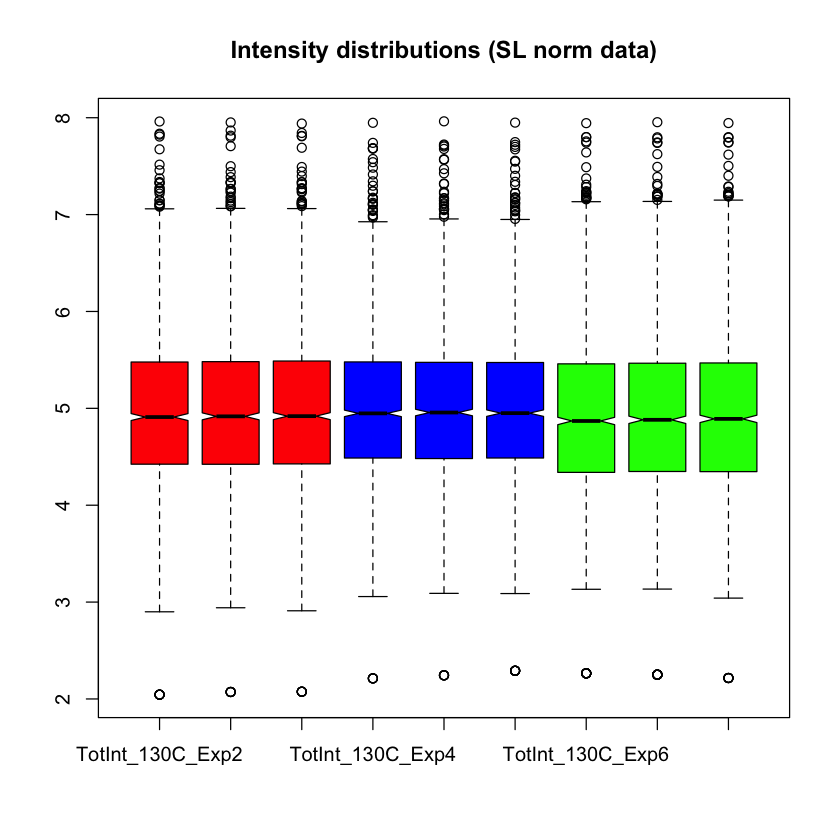

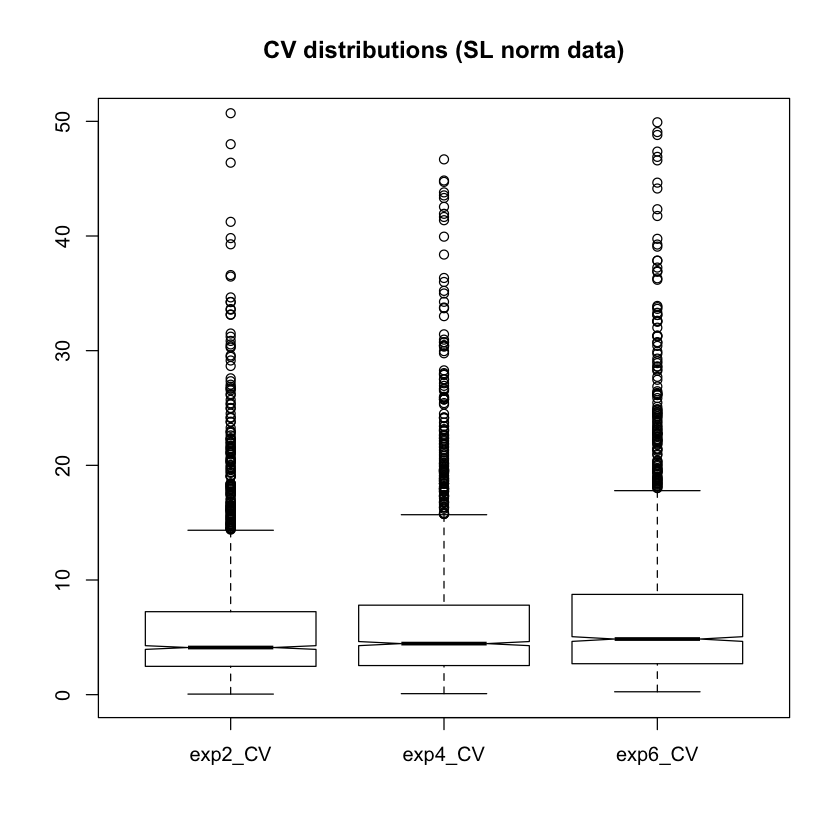

In [6]:
# check the SL normalized data
check_data(all_sl, "SL norm data") 

### SL normalization summary
The column totals are all the same; however, the column median intensities do differ a little by plex. The intensity distribution boxplots are in better horizontal alignment. The median CVs are now all between 4 and 5%.

In [7]:
# function to do medain intensity normalization
med_norm <- function(df, print_factors = TRUE) {
    # Normalizes each channel's sum to the average grand total
        # df: data frame of TMT data (one column for each channel)
        # print_factors: logical to control printing
    
    # compute norm factors and scale columns
    norm_facs <- mean(colMedians(as.matrix(df))) / colMedians(as.matrix(df))
    df_med  <- sweep(df, 2, norm_facs, FUN = "*")

    # print the normalization factors for QC check
    if (print_factors == TRUE) {
        cat("\nMedian Normalization Factors:\n ")
        cat(sprintf("%s - %0.3f\n", colnames(df), norm_facs))
    }
    
    df_med # return normalized data
}

# normalize columns to same median intensity
all_med <- med_norm(all_raw)


Median Normalization Factors:
 TotInt_130C_Exp2 - 0.750
 TotInt_131N_Exp2 - 0.786
 TotInt_131C_Exp2 - 0.788
 TotInt_130C_Exp4 - 1.012
 TotInt_131N_Exp4 - 1.067
 TotInt_131C_Exp4 - 1.205
 TotInt_130C_Exp6 - 1.367
 TotInt_131N_Exp6 - 1.287
 TotInt_131C_Exp6 - 1.163



Column Summaries (Median norm data):
  TotInt_130C_Exp2 - tot: 1,469,727,472 med: 82,548 iqr: 278,417
  TotInt_131N_Exp2 - tot: 1,445,083,411 med: 82,548 iqr: 276,093
  TotInt_131C_Exp2 - tot: 1,438,611,995 med: 82,548 iqr: 279,383
  TotInt_130C_Exp4 - tot: 1,346,617,925 med: 82,548 iqr: 251,721
  TotInt_131N_Exp4 - tot: 1,319,778,345 med: 82,548 iqr: 244,123
  TotInt_131C_Exp4 - tot: 1,339,113,775 med: 82,548 iqr: 246,305
  TotInt_130C_Exp6 - tot: 1,613,490,278 med: 82,548 iqr: 296,195
  TotInt_131N_Exp6 - tot: 1,569,218,554 med: 82,548 iqr: 292,647
  TotInt_131C_Exp6 - tot: 1,534,989,099 med: 82,548 iqr: 287,836

Median CVs (Median norm data):
  exp2_CV - med: 4.29 iqr: 4.81
  exp4_CV - med: 4.53 iqr: 5.21
  exp6_CV - med: 4.6 iqr: 5.95


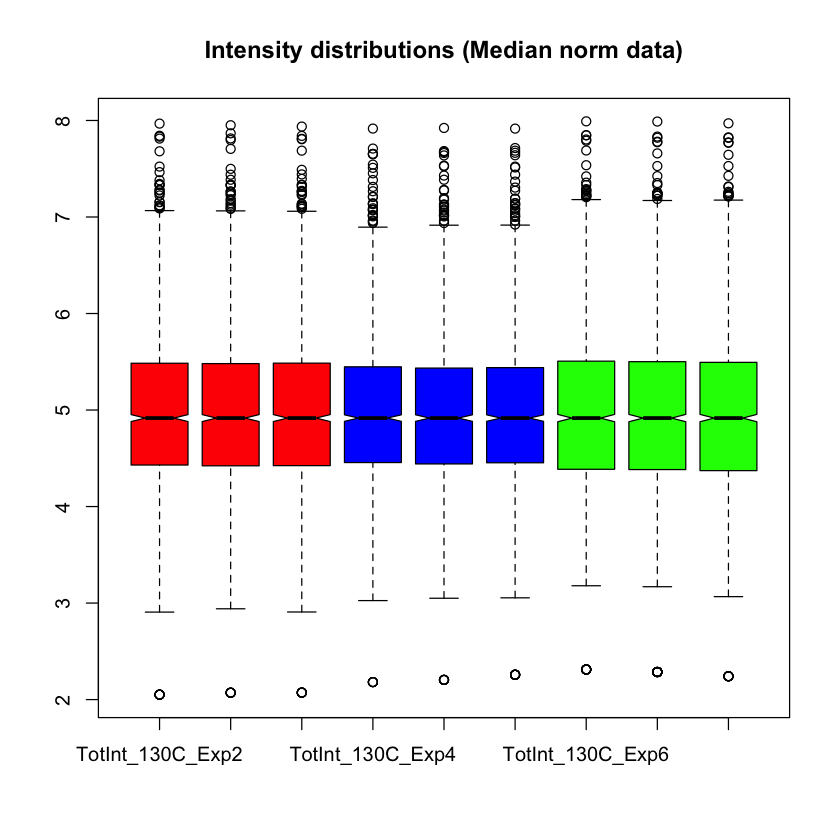

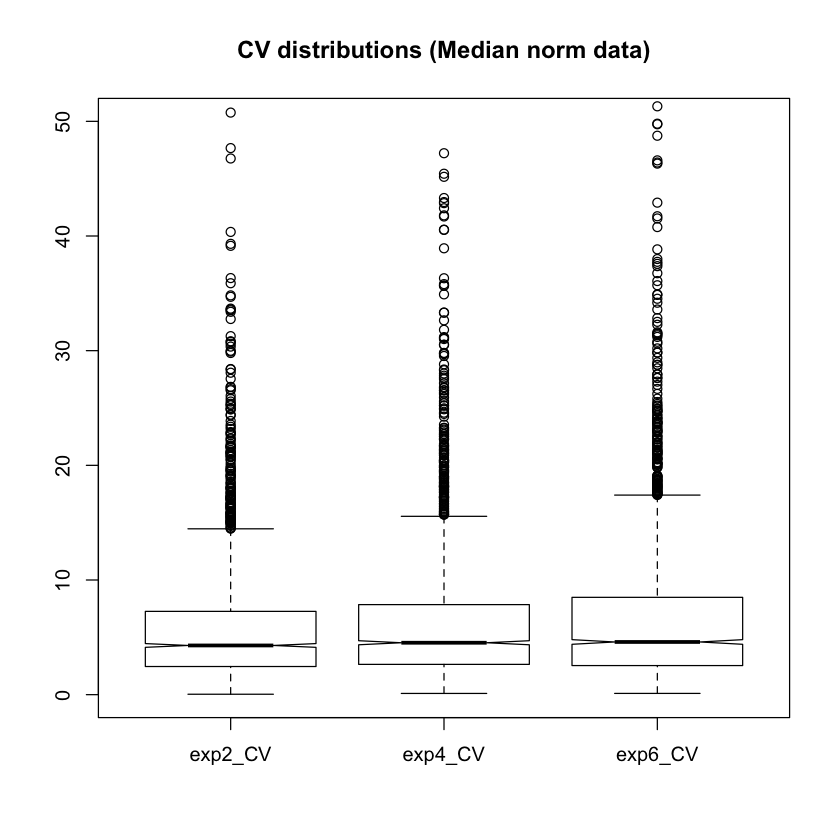

In [8]:
# check the median intensity scaled data
check_data(all_med, "Median norm data") 

### Median intensity normalization summary
We have identical median intensities in each column, but the column totals now vary a little. The centers of the intensity distribution boxplots are in horizontal alignment. Median CV values are in the 4 to 5% range. Things look pretty equivalent to the SL normalization. 

### We can also use TMM normalization from edgeR
We explored TMM and edgeR normalizations in some detail in the [dilution series notebook](https://pwilmart.github.io/TMT_analysis_examples/MAN1353_peptides_proteins.html). This normalization should focus a little more on making the centers of the data distributions similar. Getting the TMM normalized data back into a data frame to work with is a little tricky. This is explained in detail in the dilution series notebook.

In [9]:
# we will load the data into a DGEList object in edgeR then run TMM
all_raw <- data.frame(exp2_raw, exp4_raw, exp6_raw)
y <- DGEList(counts = all_raw, group = rep(1, 9))
y <- calcNormFactors(y)

# check that library sizes and normalization factors
y$sample

,group,lib.size,norm.factors
TotInt_130C_Exp2,1,1960333996,0.9891373
TotInt_131N_Exp2,1,1839411554,0.9976912
TotInt_131C_Exp2,1,1826650885,1.0007682
TotInt_130C_Exp4,1,1330669102,1.0567614
TotInt_131N_Exp4,1,1237179672,1.0568217
TotInt_131C_Exp4,1,1111150604,1.0543564
TotInt_130C_Exp6,1,1180655739,0.9345814
TotInt_131N_Exp6,1,1219129046,0.9584758
TotInt_131C_Exp6,1,1319485897,0.9599518



Column Summaries (TMM norm data):
  TotInt_130C_Exp2 - tot: 1,463,078,168 med: 82,175 iqr: 277,158
  TotInt_131N_Exp2 - tot: 1,450,534,221 med: 82,860 iqr: 277,135
  TotInt_131C_Exp2 - tot: 1,446,074,328 med: 82,976 iqr: 280,833
  TotInt_130C_Exp4 - tot: 1,369,453,052 med: 83,948 iqr: 255,989
  TotInt_131N_Exp4 - tot: 1,369,374,971 med: 85,650 iqr: 253,297
  TotInt_131C_Exp4 - tot: 1,372,576,879 med: 84,611 iqr: 252,460
  TotInt_130C_Exp6 - tot: 1,548,484,879 med: 79,223 iqr: 284,261
  TotInt_131N_Exp6 - tot: 1,509,881,782 med: 79,427 iqr: 281,581
  TotInt_131C_Exp6 - tot: 1,507,560,217 med: 81,073 iqr: 282,692

Median CVs (TMM norm data):
  exp2_CV - med: 4.17 iqr: 4.82
  exp4_CV - med: 4.48 iqr: 5.31
  exp6_CV - med: 4.46 iqr: 5.95


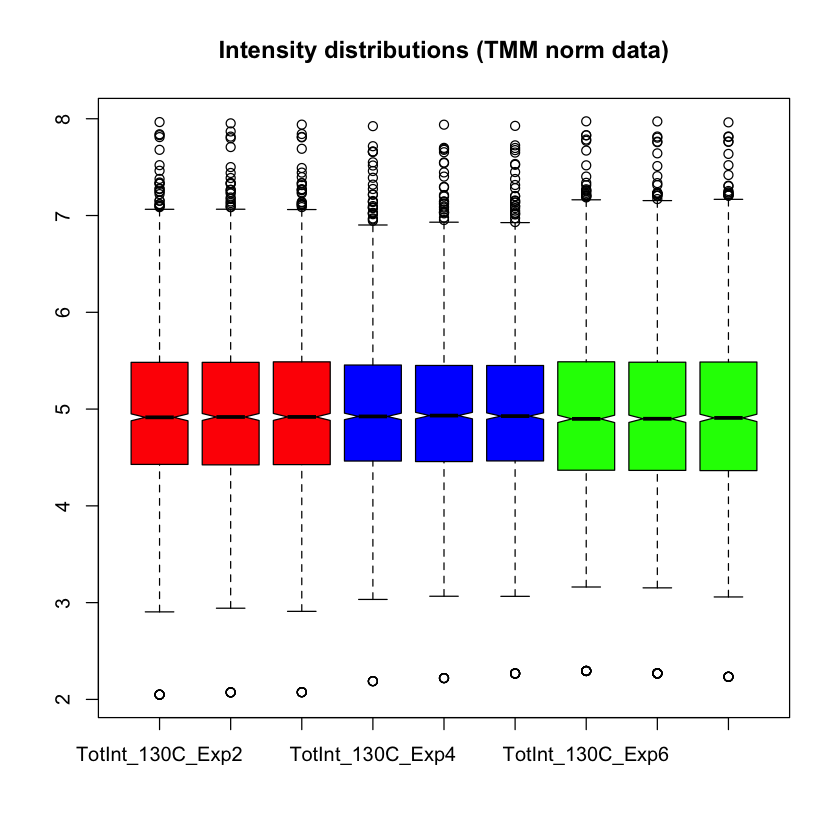

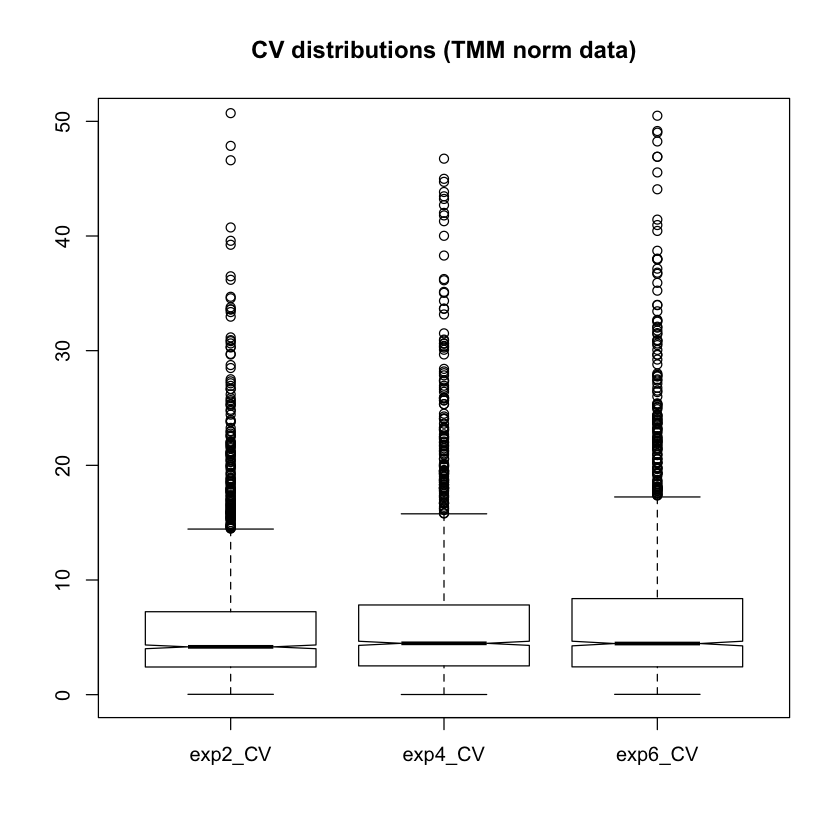

In [10]:
# use the TMM and lib.size factors to get a normalized data table
all_tmm <- sweep(all_raw, 2, y$samples$lib.size * y$samples$norm.factors, FUN = "/")

# the data above will sum up to near 1.0, we want the natural intensity scale
all_tmm <- all_tmm * mean(y$samples$lib.size)

# see if column totals are the same, etc.
check_data(all_tmm, "TMM norm data") 

### TMM normalization summary
TMM is really designed to remove compositional bias, so library sizes typically end up different when all is said and done. TMM normalization kind of splits the difference between the other two normalization methods. We do not have identical totals or medians, but they are very similar between channels. CV medians are still in the 4 to 5% range.

### We can also try quantile normalization
Quantile normalization was developed for microarray data and is considered a moderately aggressive method. Quantile normalization does not make different distributions similar - it makes the distributions exactly the same. It is an interesting idea and you can read more about it [here](https://en.wikipedia.org/wiki/Quantile_normalization). The dataset should have a lot of rows because the method increases the granularity of the data points. The number of actual data points after quantile normalization is reduced (divided by) by the number of columns (samples) in the dataset. 

The assumption that all of the samples in your experiment should have exactly the same distribution of measured values is pretty strong. I think that this is not true enough often enough to recommend this method for proteomics experiments. That said, if I do not show everyone's favorite normalization technique, someone will be unhappy. Using 4 different normalization methods should be sufficient, so we will stop after quantile normalization and get back to the topic of the IRS method.


Column Summaries (Quantile norm data):
  TotInt_130C_Exp2 - tot: 1,447,184,649 med: 82,548 iqr: 272,334
  TotInt_131N_Exp2 - tot: 1,447,185,066 med: 82,548 iqr: 272,334
  TotInt_131C_Exp2 - tot: 1,447,185,066 med: 82,548 iqr: 272,334
  TotInt_130C_Exp4 - tot: 1,447,185,166 med: 82,548 iqr: 272,334
  TotInt_131N_Exp4 - tot: 1,447,185,066 med: 82,548 iqr: 272,334
  TotInt_131C_Exp4 - tot: 1,447,183,286 med: 82,548 iqr: 272,334
  TotInt_130C_Exp6 - tot: 1,447,183,662 med: 82,548 iqr: 272,334
  TotInt_131N_Exp6 - tot: 1,447,186,787 med: 82,548 iqr: 272,334
  TotInt_131C_Exp6 - tot: 1,447,184,649 med: 82,548 iqr: 272,334

Median CVs (Quantile norm data):
  exp2_CV - med: 4.21 iqr: 4.76
  exp4_CV - med: 4.71 iqr: 5.76
  exp6_CV - med: 4.35 iqr: 5.69


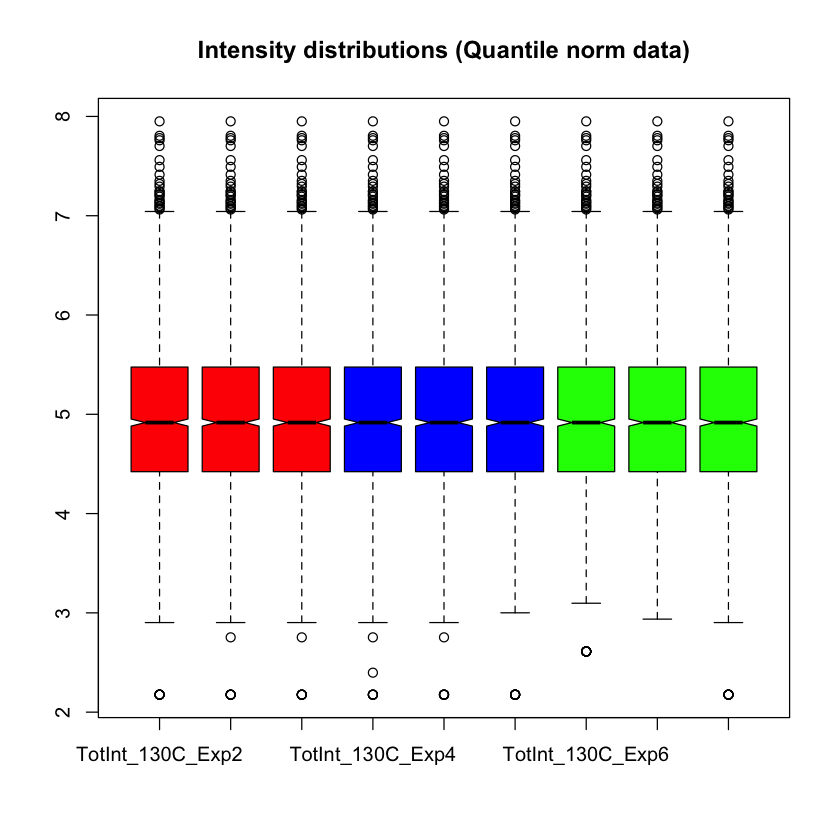

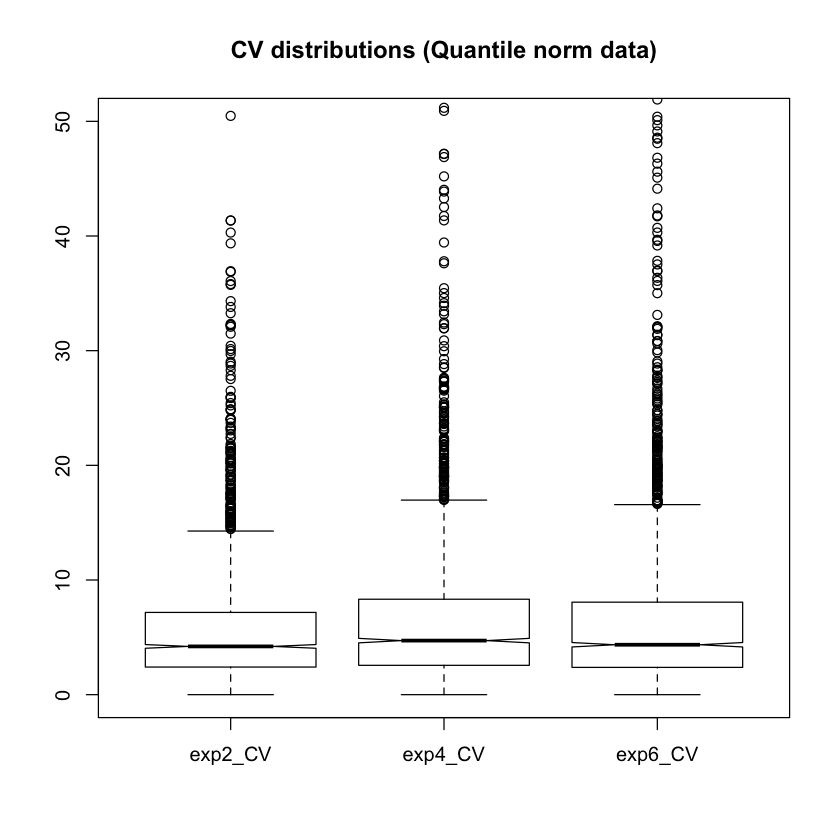

In [11]:
# this function comes from Bioconductor
all_quantile <- as.data.frame(normalize.quantiles(as.matrix(all_raw)))
colnames(all_quantile) <- colnames(all_raw) # add back the column names

# get the quantile norm data summaries
check_data(all_quantile, "Quantile norm data")

### Quantile normalization really does make things similar
The column totals are not exactly identical because of how rank ties are handled. The medians are identical, and the boxplots are pretty much identical, too. The median CVs stay in the 4 to 5% range.

## See what the reference channels are like in a single plex
We will pick experiment 4 and make some channel-to-channel scatter plot grids for the raw data and the normalized data. We will pick just one plex here so that the scatter plots are nice and large.

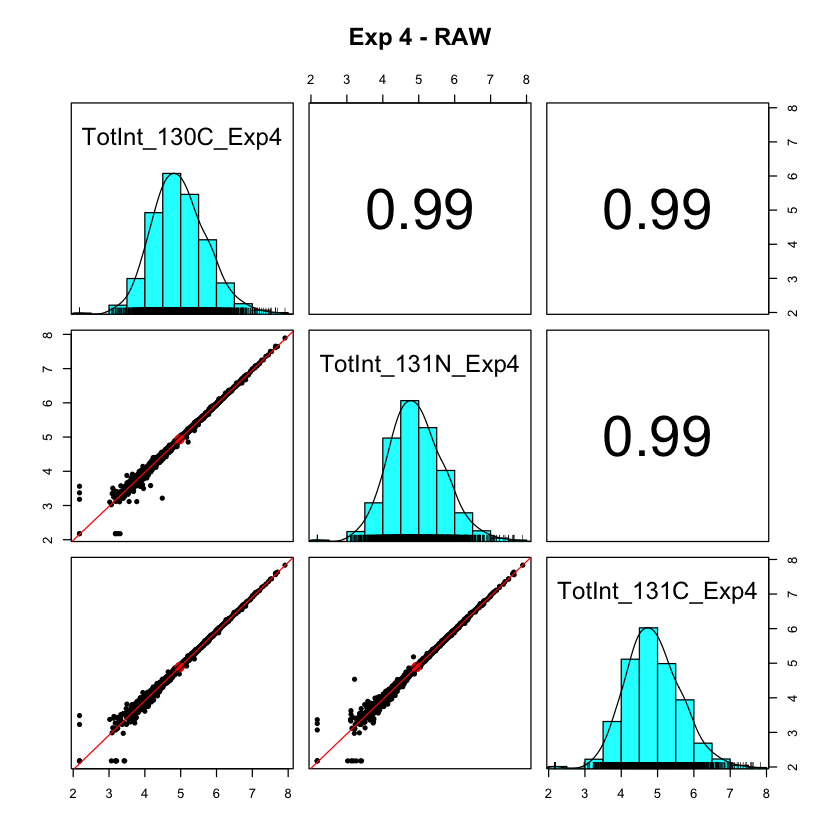

In [12]:
# set indices for experiment 4
exp4 <- 4:6

# plot the raw data
pairs.panels(log10(all_raw[exp4]), lm = TRUE, main = "Exp 4 - RAW")

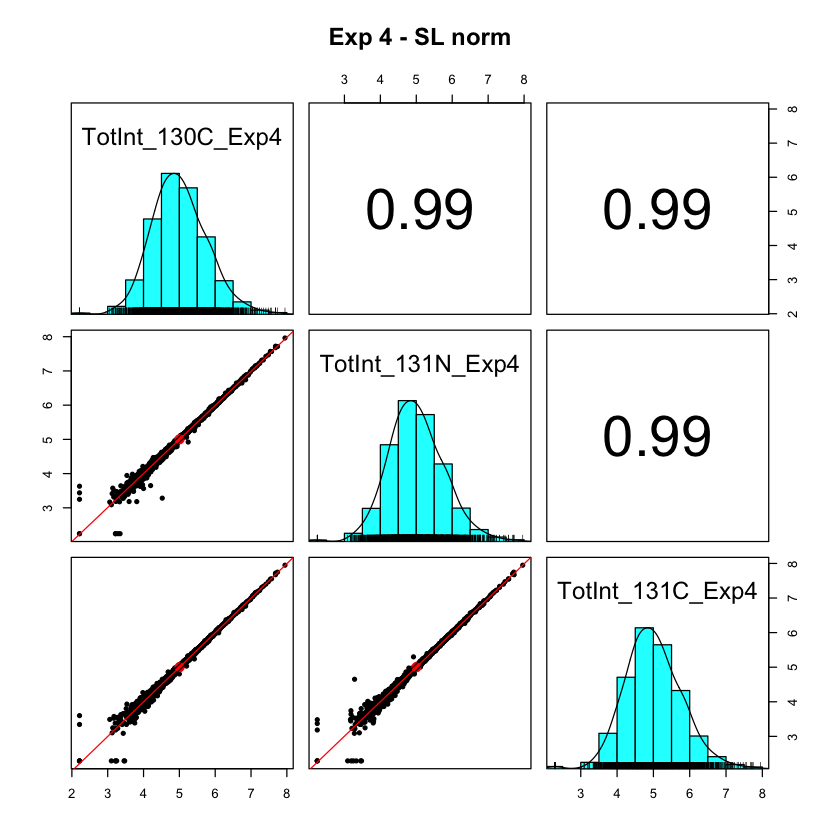

In [13]:
# plot the SL norm data
pairs.panels(log10(all_sl[exp4]), lm = TRUE, main = "Exp 4 - SL norm")

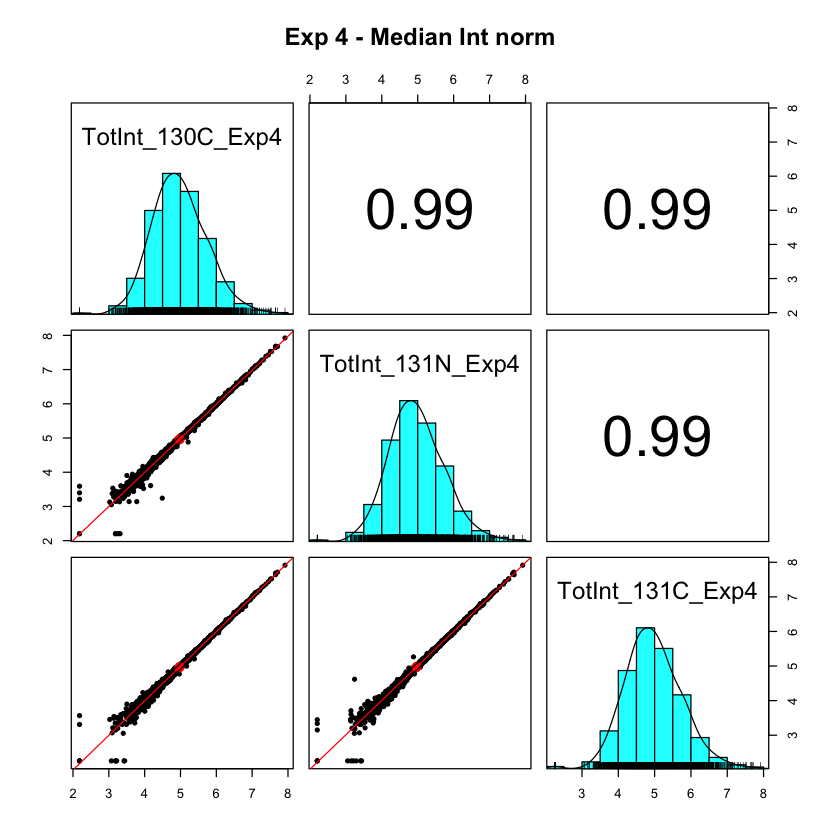

In [14]:
# plot the median norm data
pairs.panels(log10(all_med[exp4]), lm = TRUE, main = "Exp 4 - Median Int norm")

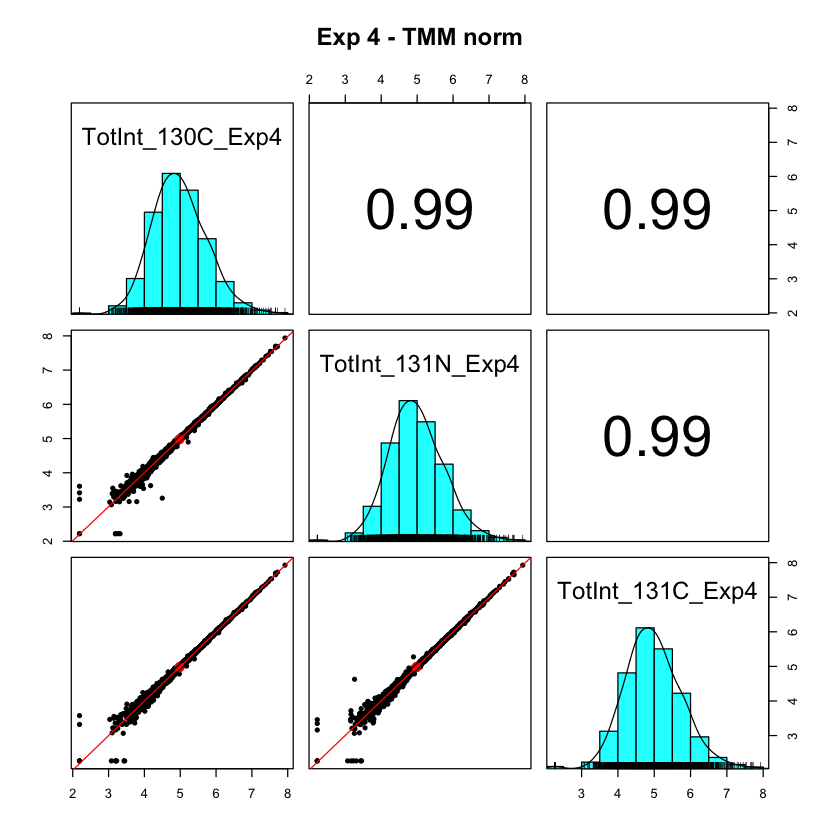

In [15]:
# plot the TMM norm data
pairs.panels(log10(all_tmm[exp4]), lm = TRUE, main = "Exp 4 - TMM norm")

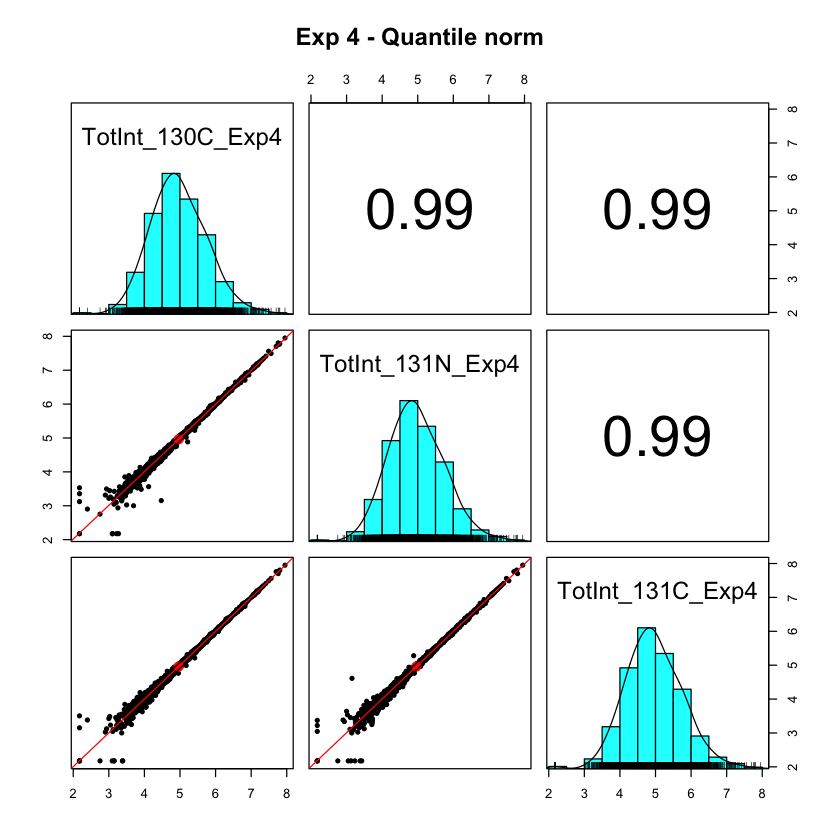

In [16]:
# plot the Quantile norm data
pairs.panels(log10(all_quantile[exp4]), lm = TRUE, main = "Exp 4 - Quantile norm")

## The plots all look the same!
What is changing (and that we cannot see too well) are the slopes of the trend lines. They will be closer to 1.0 for the normalized data. These single factor normalization methods do not affect things like correlation coefficients or general appearance of scatter plots.

### Replicate data in single plexes are nearly identical
We have the usual phenomena that the quality of the measurements gets worse as the abundance gets lower. There is more scatter in the data in the lower left parts of the scatter plots than in the upper right parts of the plots. We also have a few data points that are outliers (maybe an interfering ion in one channel) and some points where there was a missing value (the points near the x and y axis lines).

## What about data between plexes?
Remember, **these samples are identical** to each other whether they are in the same plex or not. We have extra reference channels in experiments 2, 4, and 6. Let's see how similar those channels are to each other before and after the different normalizations.

We will look at some distribution summaries first, then do some scatter plot grids. We will start with the raw data so we can see the effects of normalization. Note that the CV distribution boxplot now has a maximum value of 100% instead of 50% used above.


Column Summaries (Extra channels - raw):
  TotInt_130C_Exp2 - tot: 1,960,333,996 med: 110,104 iqr: 371,355
  TotInt_130C_Exp4 - tot: 1,330,669,102 med: 81,571 iqr: 248,739
  TotInt_130C_Exp6 - tot: 1,180,655,739 med: 60,404 iqr: 216,738

Median CVs (Extra channels - raw):
  Extras - med: 39.41 iqr: 30.96


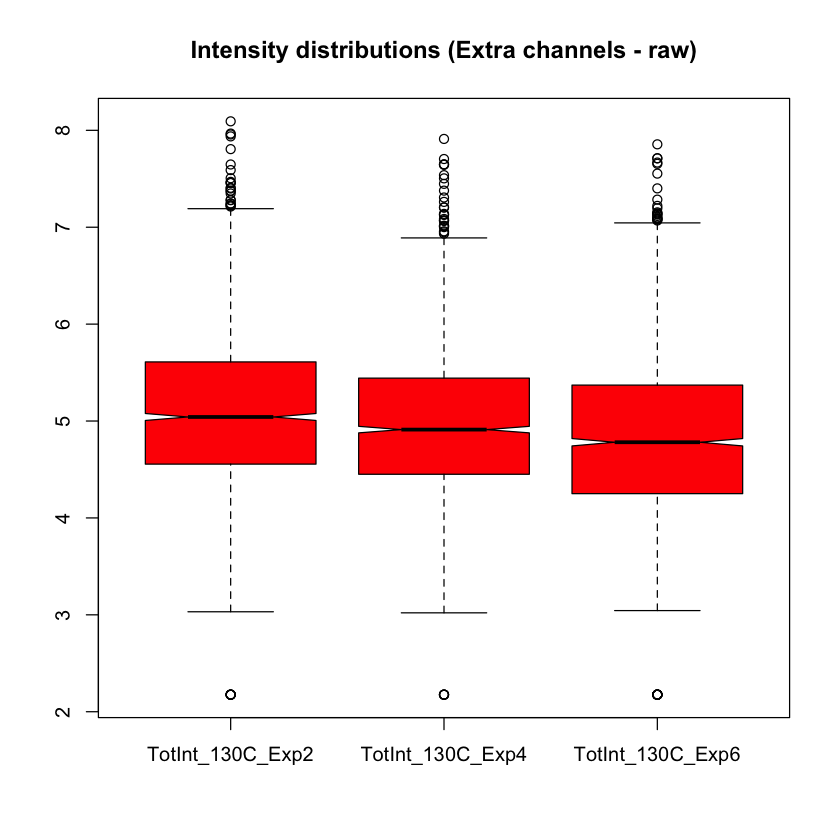

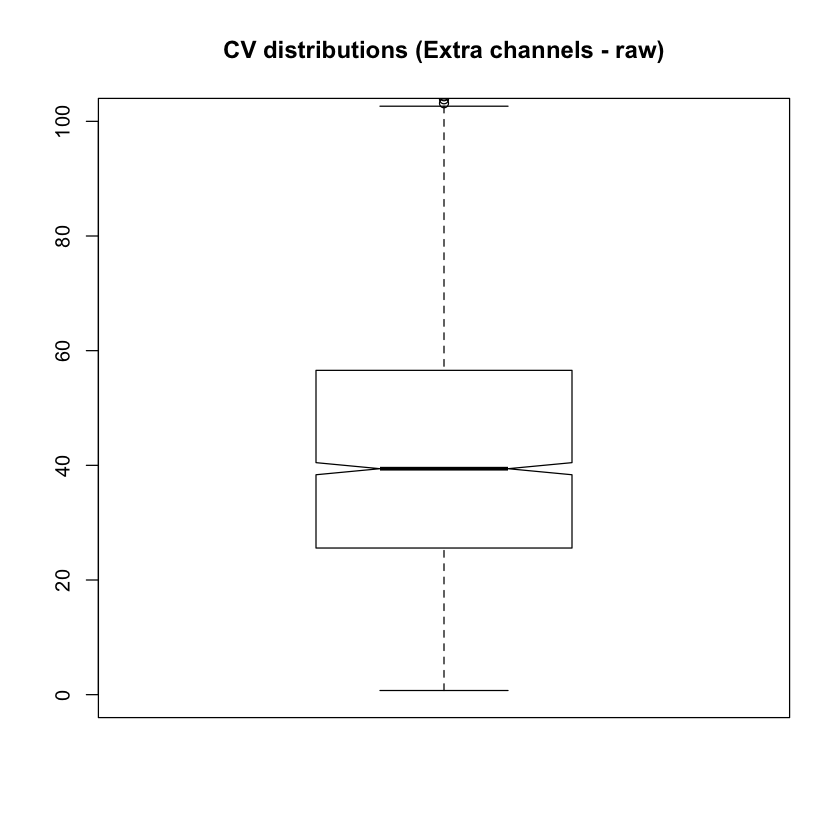

In [17]:
# extra channels from RAW data
extras <- c(1, 4, 7)
check_data(all_raw[extras], "Extra channels - raw")

#### Raw data needs normalization
It is interesting to note that the median protein CV in the raw data is almost 40%!

### See what effect normalization has
We saw above that the different normalization methods were all pretty similar. We will just look at TMM and quantile normalizations to save some time.


Column Summaries (Extra channels - TMM norm):
  TotInt_130C_Exp2 - tot: 1,463,078,168 med: 82,175 iqr: 277,158
  TotInt_130C_Exp4 - tot: 1,369,453,052 med: 83,948 iqr: 255,989
  TotInt_130C_Exp6 - tot: 1,548,484,879 med: 79,223 iqr: 284,261

Median CVs (Extra channels - TMM norm):
  Extras - med: 28.34 iqr: 29.24


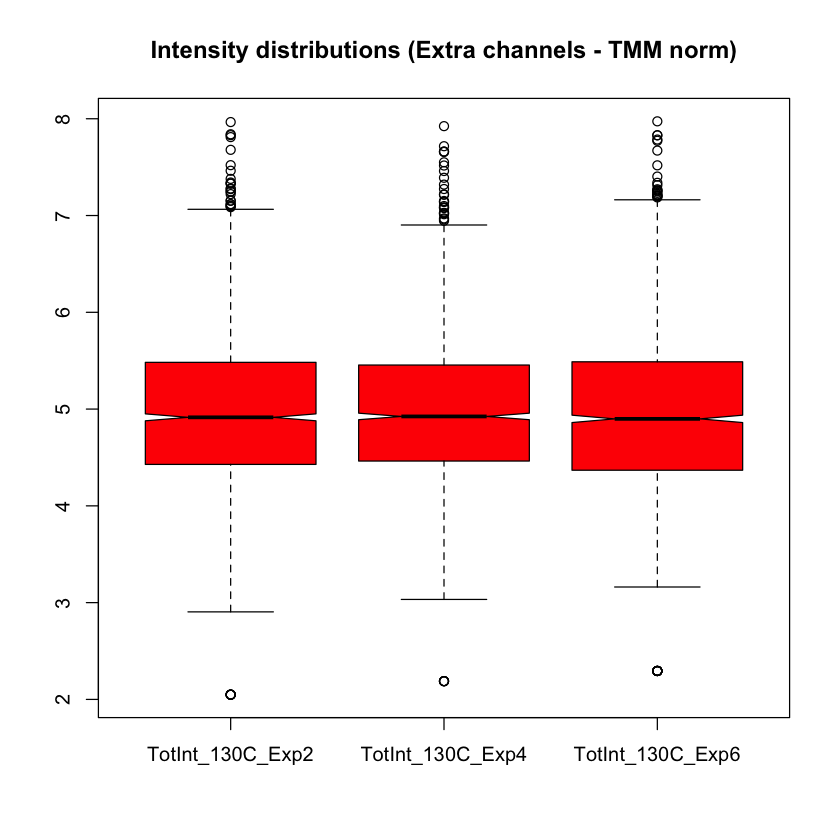

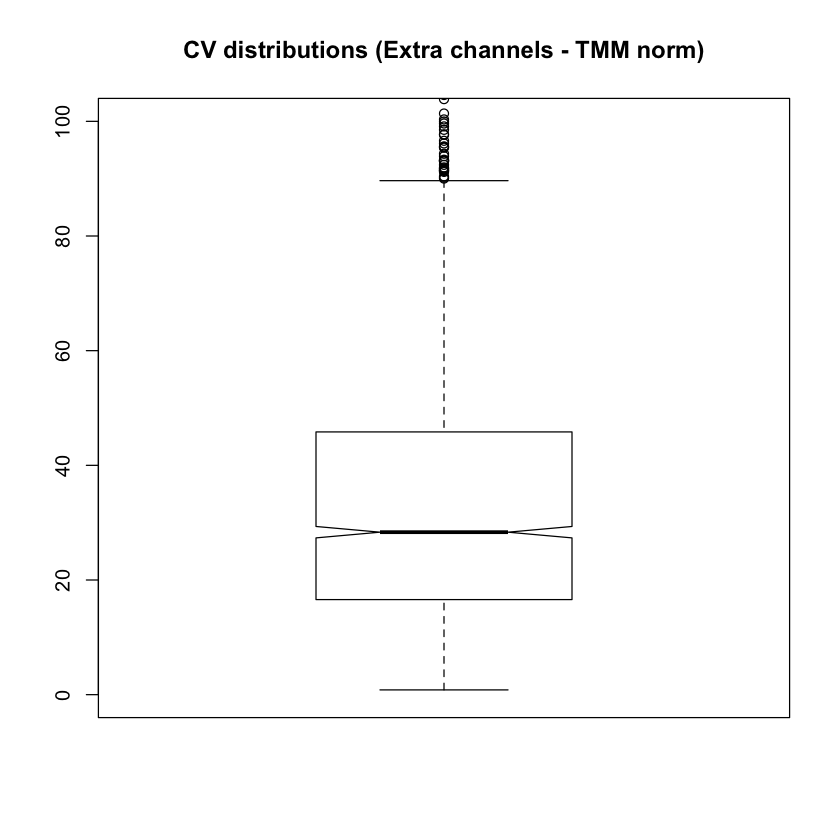

In [18]:
# check the effect of TMM norm on the extra channels
check_data(all_tmm[extras], "Extra channels - TMM norm")

#### Median CV value improves to 28%


Column Summaries (Extra channels - Quantile norm):
  TotInt_130C_Exp2 - tot: 1,447,184,649 med: 82,548 iqr: 272,334
  TotInt_130C_Exp4 - tot: 1,447,185,166 med: 82,548 iqr: 272,334
  TotInt_130C_Exp6 - tot: 1,447,183,662 med: 82,548 iqr: 272,334

Median CVs (Extra channels - Quantile norm):
  Extras - med: 28.1 iqr: 28.59


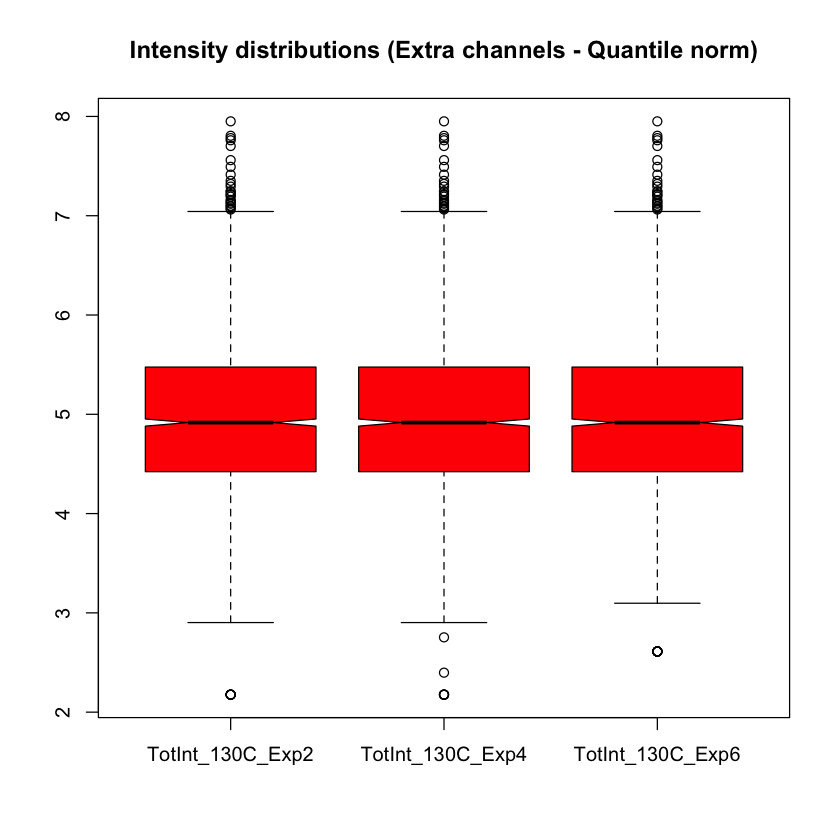

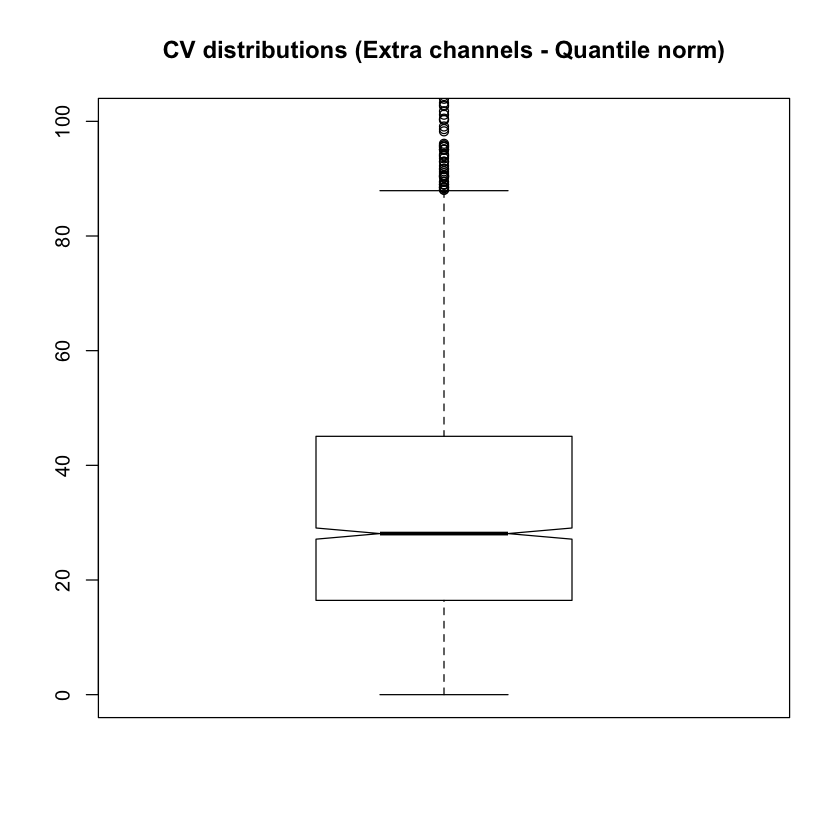

In [19]:
# check effect of quantile norm on extra channels
check_data(all_quantile[extras], "Extra channels - Quantile norm")

### Either TMM or quantile normalization had similar effect
Normalizations make the channels between plexes more similar (column totals and median intensities) and reduce the median protein CV compared to the raw data. **NOTE:** a 28% median CV is better than a 40% CV, but it is not good and much worse than 5% CVs seen between references in the same plex. 

We seem to have some sort of fundamental difference in the data between plexes compared to data within a single plex. Let's move on to the scatter plot grids.

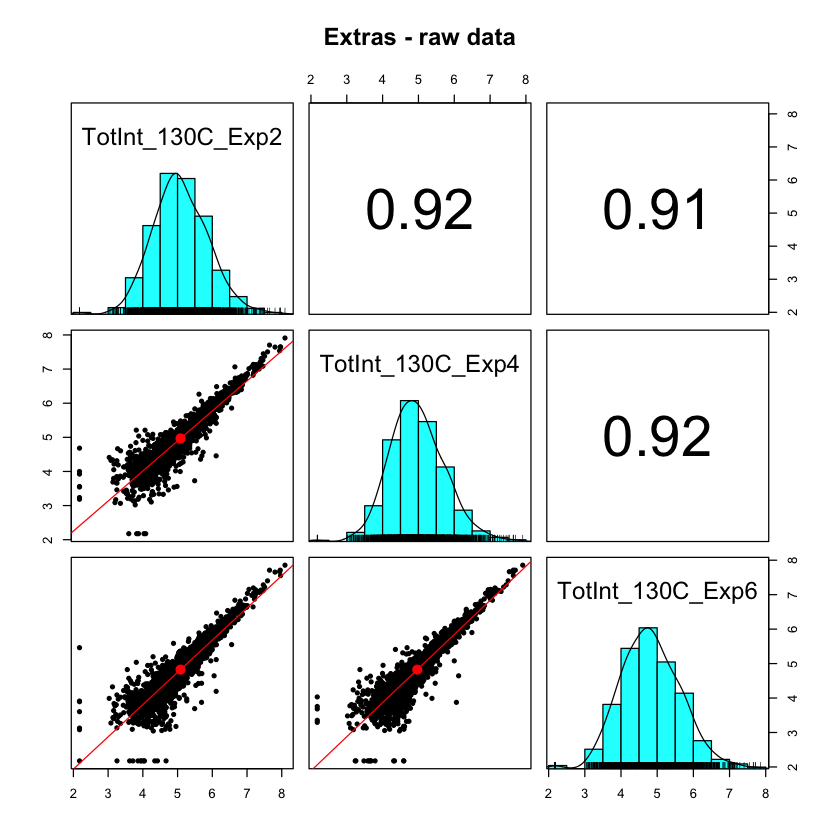

In [20]:
# raw data first
pairs.panels(log10(all_raw[extras]), lm = TRUE, main = "Extras - raw data")

### Raw data look TERRIBLE

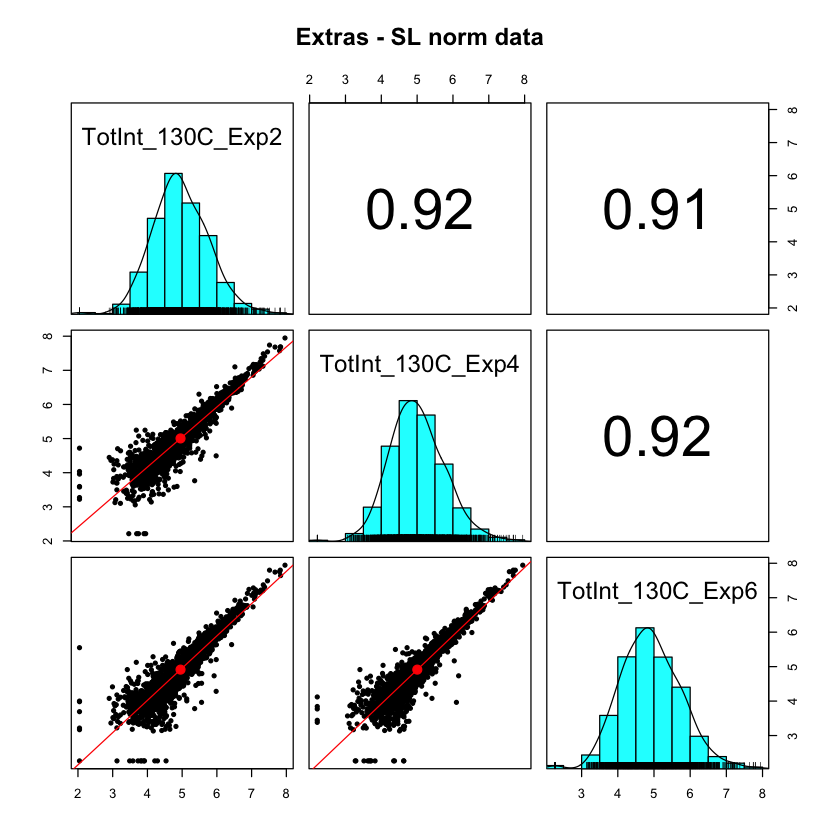

In [21]:
# SL norm data
pairs.panels(log10(all_sl[extras]), lm = TRUE, main = "Extras - SL norm data")

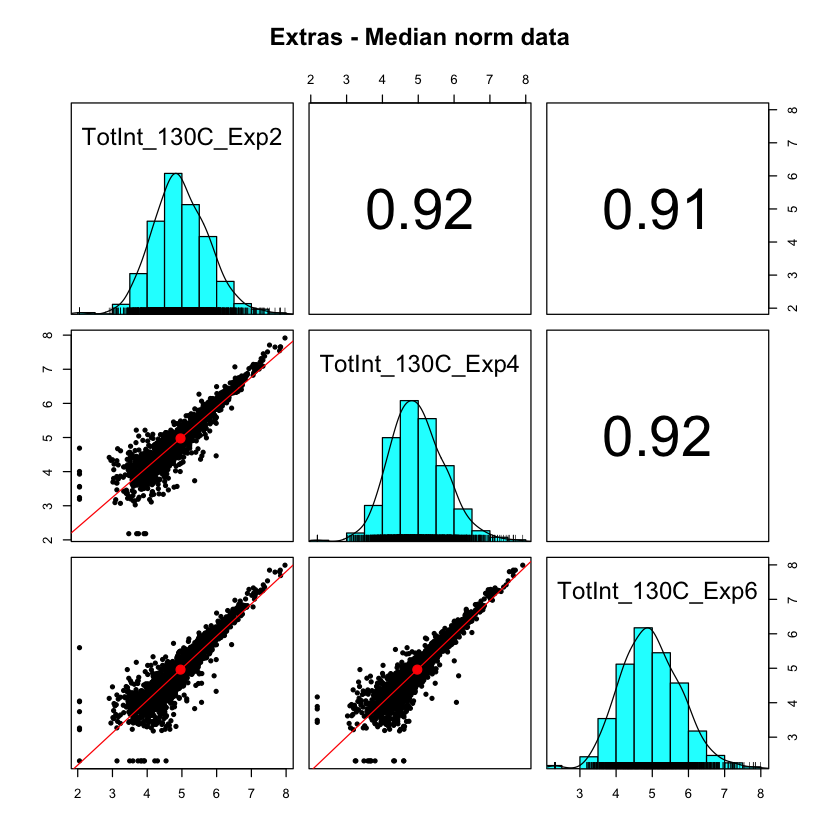

In [22]:
# Median norm data
pairs.panels(log10(all_med[extras]), lm = TRUE, main = "Extras - Median norm data")

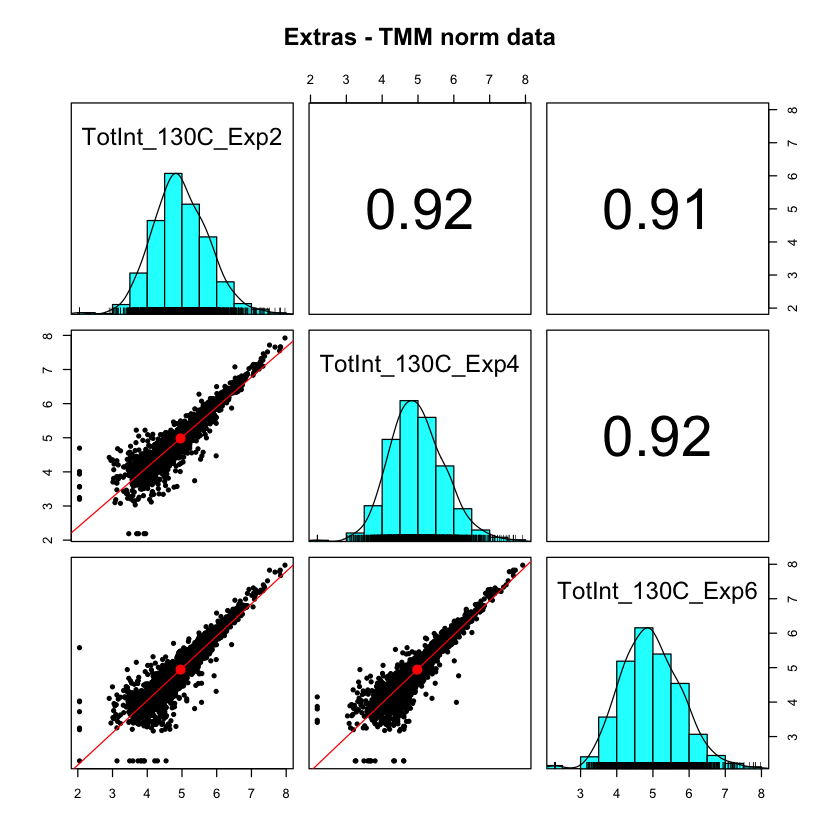

In [23]:
# TMM norm data
pairs.panels(log10(all_tmm[extras]), lm = TRUE, main = "Extras - TMM norm data")

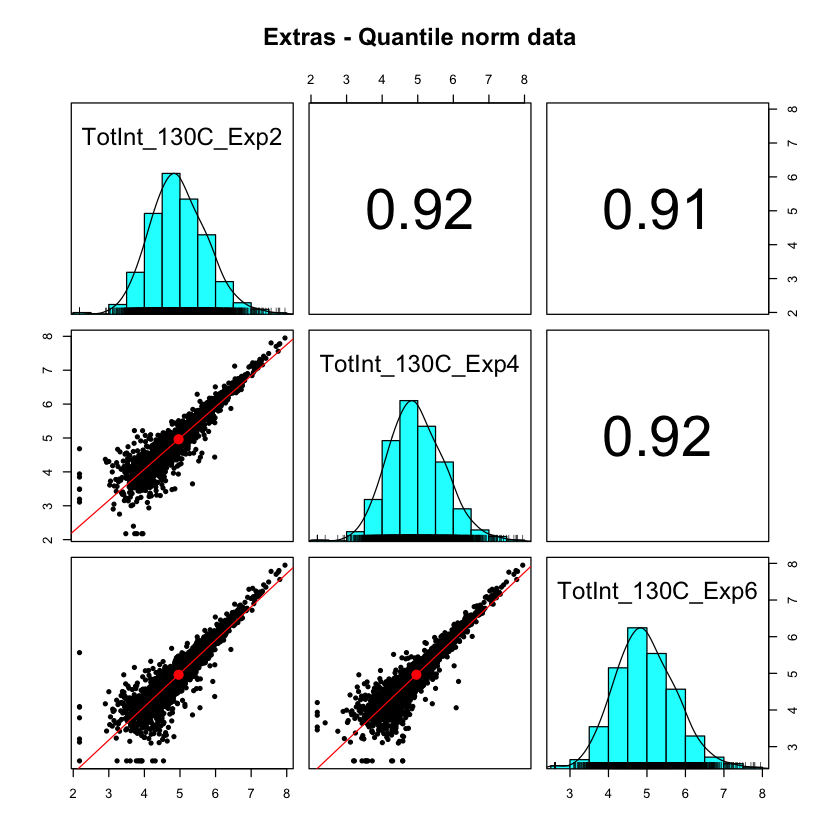

In [24]:
# quantile norm data
pairs.panels(log10(all_quantile[extras]), lm = TRUE, main = "Extras - Quantile norm data")

## Wait - all of the normalization methods are FAILING!

#### Boxplots and summary data looked great - what went wrong?
The normalization methods are really dealing with global aspects of the data. They match distribution areas or centers or something else along those lines. What is strikingly different about within plex versus between plex data are CV values and the "scatter" in the scatter plots. Things like the intensity distribution boxplots, column totals, or median intensities **completely** hide the warts in the data when we are comparing between plexes.

#### The difference really comes down to comparing channels from the same scan to channels from different scans
Ironically, if you sum the reporter ions from different PSM scans into peptides and then into proteins **within the same plex**, we do not see any problems. That is because the sums are all done in parallel and that maintains the relative reporter ion pattern between channels. There is a relationship between the PSMs, peptides, and proteins in each plex. This does not hold at any level between plexes. The PSMs in one plex have no relationship to the PSMs in a different plex. We will not have the same set of peptide features selected for fragmentation in each plex. Even if we have common features, the analyte abundance when the MS2 scan was taken will not be the same.

These dramatic differences in the nature of PSMs in each plex percolate up the food chain and cause differences for peptides and proteins. We know that our plexes are composed of related samples so they cannot be completely unrelated to each other. We will mostly see the same things between plexes, and the sameness will be better for proteins than for peptides. Things like "match between run" in MS1 label free exist because the eluting features are more similar between runs of related samples than the sets of MS2 identifications. Isobaric labeling is really a **snapshot** mass spec method and we do not expect the snapshots between analyses of complex peptide digests to be robustly the same. 

This is what is behind the ugly scatter plots above. Let's do a large scatter plot grid to emphasize the **fundamental** difference that happens when we transition from a single plex to multiple plexes. 

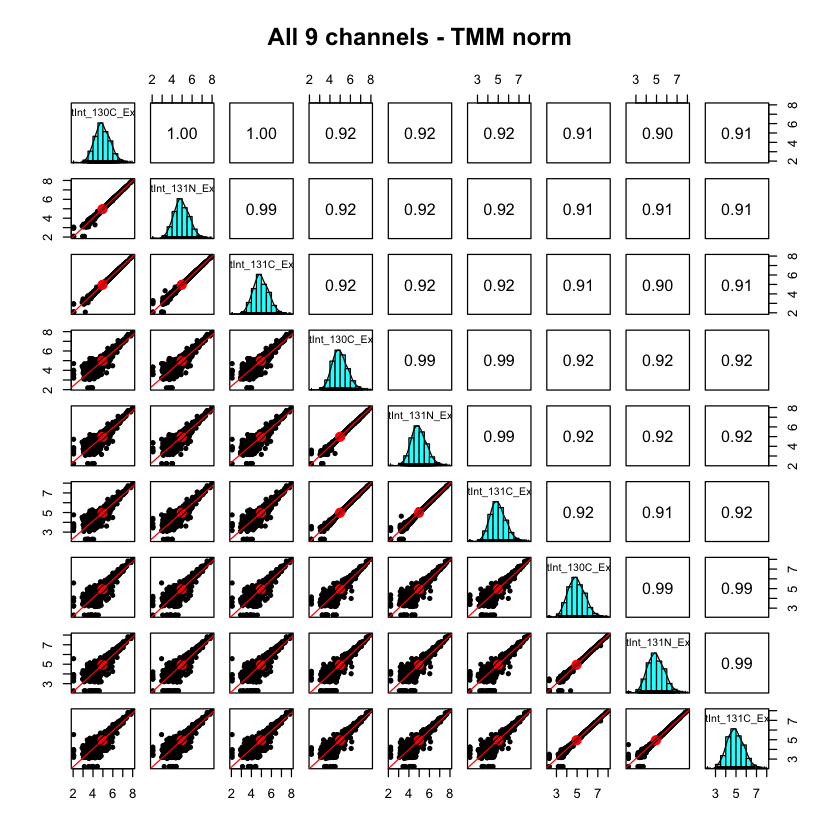

In [25]:
pairs.panels(log10(all_tmm), lm = TRUE, main = "All 9 channels - TMM norm")

## Channels are "tight" within plexes and "not so much" between plexes
All 9 channels above are **IDENTICAL**. Let me rephrase that. All 9 channels above are **IDENTICAL** (sorry, I can' think of any other way to emphasize this). The first 3 channels have scatter plots with the points tight to the trend line. So do the middle 3 and the bottom 3. All scatter plots involving channels between different plexes are big, ugly blobs (BUBs - does giving something an acronym add an air of legitimacy?). 

## IRS to the rescue!
As mentioned at the top of this notebook, reference channels will let us measure how the MS2 sampling changed the data and let us correct that. Think of the reference channels as protein rulers. We will get the protein ruler measures in each plex from the references. We can then compare those measures between plexes and make them the same. This should put all measures on the same scale and make the BUBs go away.

#### IRS Steps:
- locate the reference channels correctly
- average (arithmetic) the two reference channels
- average (geometric) the averages
- compute IRS factors (geometric average divided by the arithmetic averages)
- scale each plex by the IRS factors (done independently for each protein)

In [26]:
# let's do IRS by hand

# make data frame with averages of the two references per plex
irs_factors <- data.frame(avePoolExp2 = rowMeans(all_sl[2:3]), 
                          avePoolExp4 = rowMeans(all_sl[5:6]), 
                          avePoolExp6 = rowMeans(all_sl[8:9]))

irs_factors$geomean <- apply(irs_factors, 1, function(x) exp(mean(log(x))))
                             
irs_factors$fac2 <- irs_factors$geomean / irs_factors$avePoolExp2
irs_factors$fac4 <- irs_factors$geomean / irs_factors$avePoolExp4
irs_factors$fac6 <- irs_factors$geomean / irs_factors$avePoolExp6
                             
head(irs_factors)

avePoolExp2,avePoolExp4,avePoolExp6,geomean,fac2,fac4,fac6
88241253,90379710,89002630,89203484,1.0109045,0.9869857,1.0022567
67426323,51506798,41830805,52569045,0.7796517,1.0206234,1.2567065
69321161,50007849,62043810,59914806,0.8643076,1.1981080,0.9656855
31291016,53874357,62539103,47240861,1.5097260,0.8768710,0.7553812
63555144,36366115,55747537,50507720,0.7947070,1.3888676,0.9060081
49918700,48813069,55155104,51222609,1.0261207,1.0493626,0.9287012



Column Summaries (IRS norm data):
  TotInt_130C_Exp2 - tot: 1,421,516,138 med: 78,398 iqr: 266,598
  TotInt_131N_Exp2 - tot: 1,421,418,210 med: 79,947 iqr: 259,272
  TotInt_131C_Exp2 - tot: 1,419,533,583 med: 78,383 iqr: 263,997
  TotInt_130C_Exp4 - tot: 1,421,224,887 med: 79,653 iqr: 266,126
  TotInt_131N_Exp4 - tot: 1,421,548,850 med: 78,728 iqr: 260,471
  TotInt_131C_Exp4 - tot: 1,419,402,943 med: 79,139 iqr: 262,995
  TotInt_130C_Exp6 - tot: 1,422,358,502 med: 76,292 iqr: 251,794
  TotInt_131N_Exp6 - tot: 1,420,271,663 med: 78,765 iqr: 261,836
  TotInt_131C_Exp6 - tot: 1,420,680,130 med: 79,421 iqr: 262,838

Median CVs (IRS norm data):
  exp2_CV - med: 4.11 iqr: 4.77
  exp4_CV - med: 4.45 iqr: 5.26
  exp6_CV - med: 4.85 iqr: 6.04


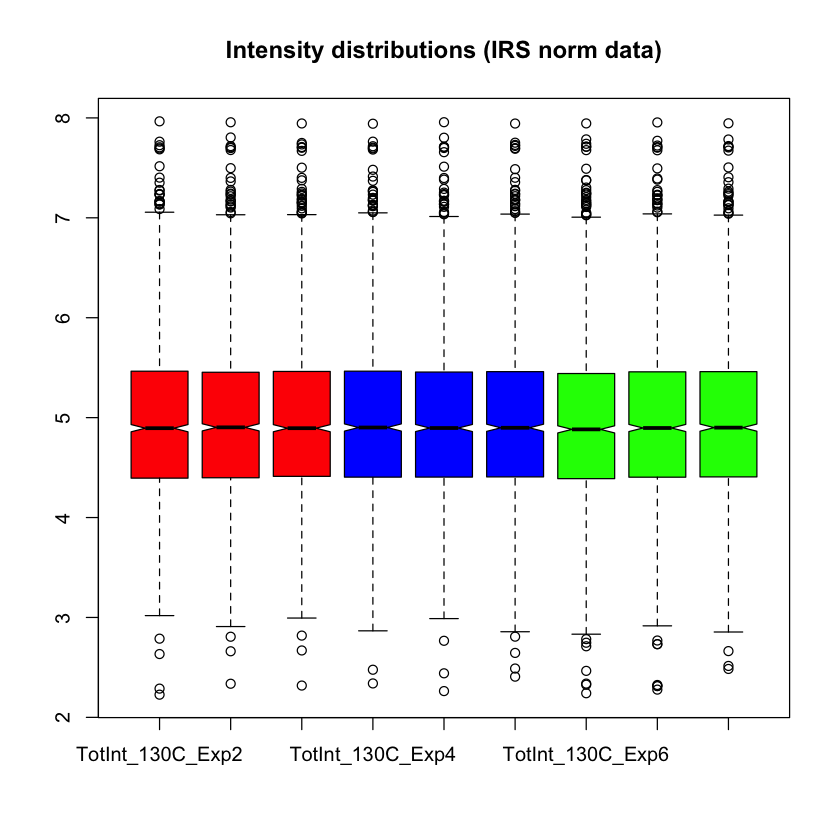

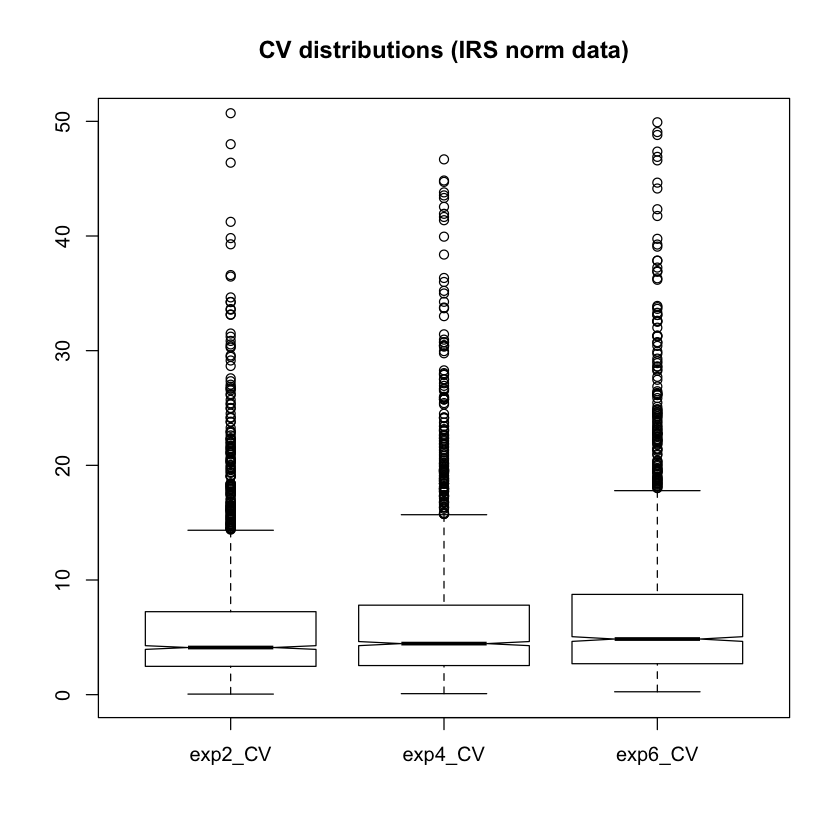

In [27]:
# make new data frame with normalized data
all_irs <- all_sl[1:3] * irs_factors$fac2
all_irs <- cbind(all_irs, all_sl[4:6] * irs_factors$fac4)
all_irs <- cbind(all_irs, all_sl[7:9] * irs_factors$fac6)

# check the IRS normalized data
check_data(all_irs, "IRS norm data")

### IRS normalized data looks as good as other normalized data on global scales

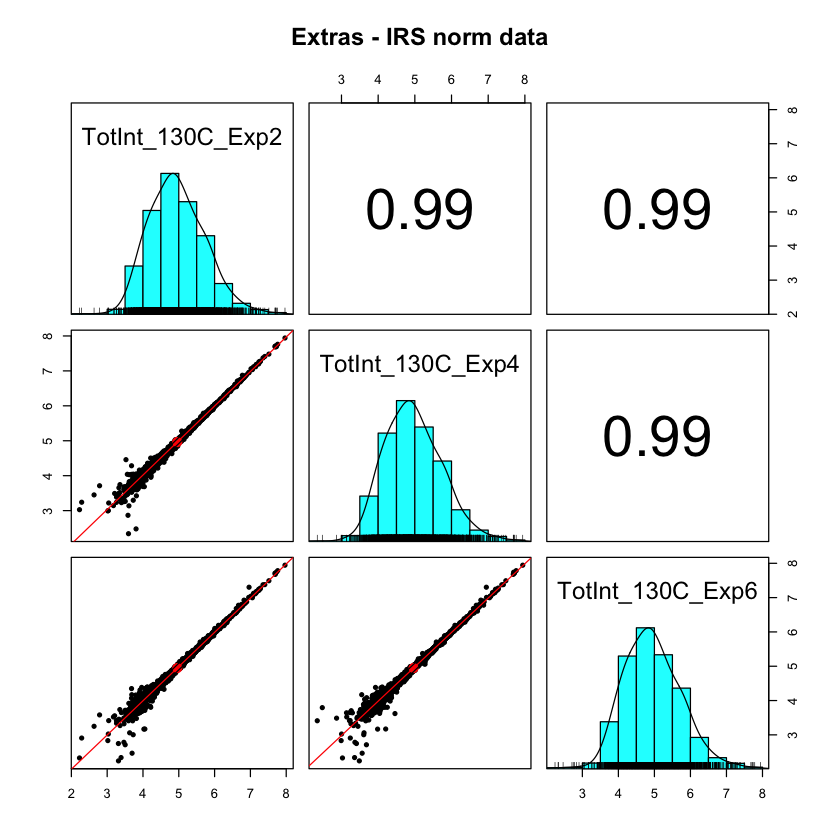

In [28]:
# make big scatter plots
pairs.panels(log10(all_irs[extras]), lm = TRUE, main = "Extras - IRS norm data")

## IRS just fixed the extra channel data!

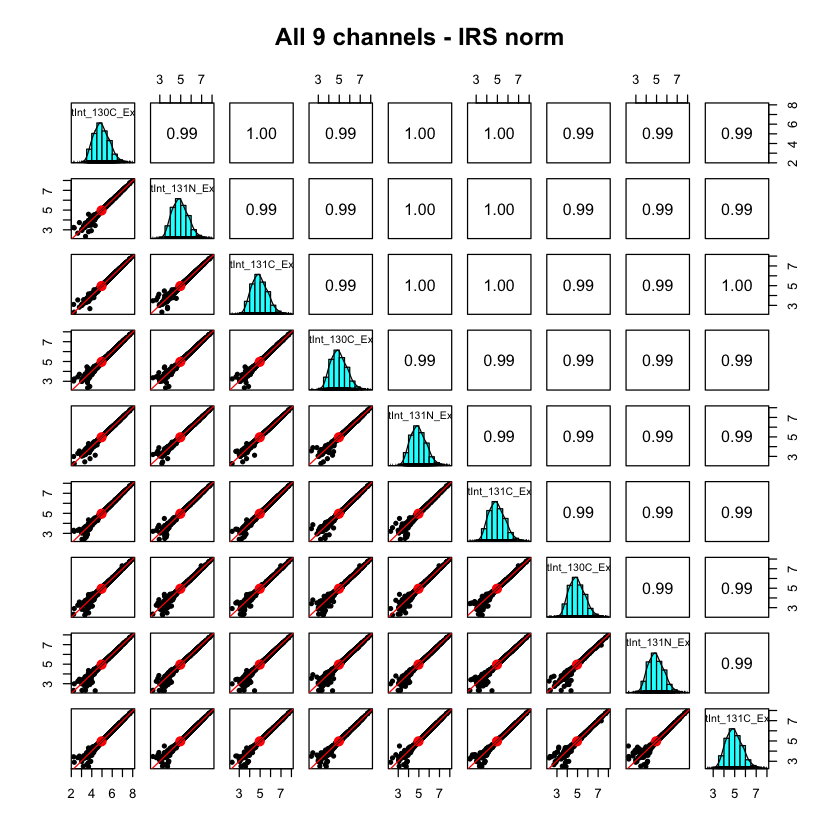

In [29]:
# make scatter plots across all 3 plexes
pairs.panels(log10(all_irs), lm = TRUE, main = "All 9 channels - IRS norm")

## IRS does just one thing and does it well
The IRS method does just one thing - it removes MS2 sampling variation. Even though we took duplicate measures of the reference channel in each plex, the average of those measures still has some uncertainty. The uncertainties in the protein rulers in each plex do propagate into the final IRS-adjusted values. That is just the cost of admission in large isobaric labeling experiments. IRS may not be perfect, but there is really **no alternative**.

Is the data without IRS completely worthless? That is an interesting question. The BUB (big, ugly blobs) scatter plots still had 0.91 for correlation coefficients, which is a pretty large positive correlation. The BUB appearance and CV values indicate that there is a lot of variance in the data without IRS. 

We know that these samples are the same, so we can take intensity ratios and look at the distributions of the log2 R values. Those will be bell shaped and their widths near the bases of the distributions will tell us what kind of ballpark fold-changes might be statistically significant when we compare biological samples. We will need to have bigger differences between biological replicates than we have between technical replicates to actually be able to measure anything.  

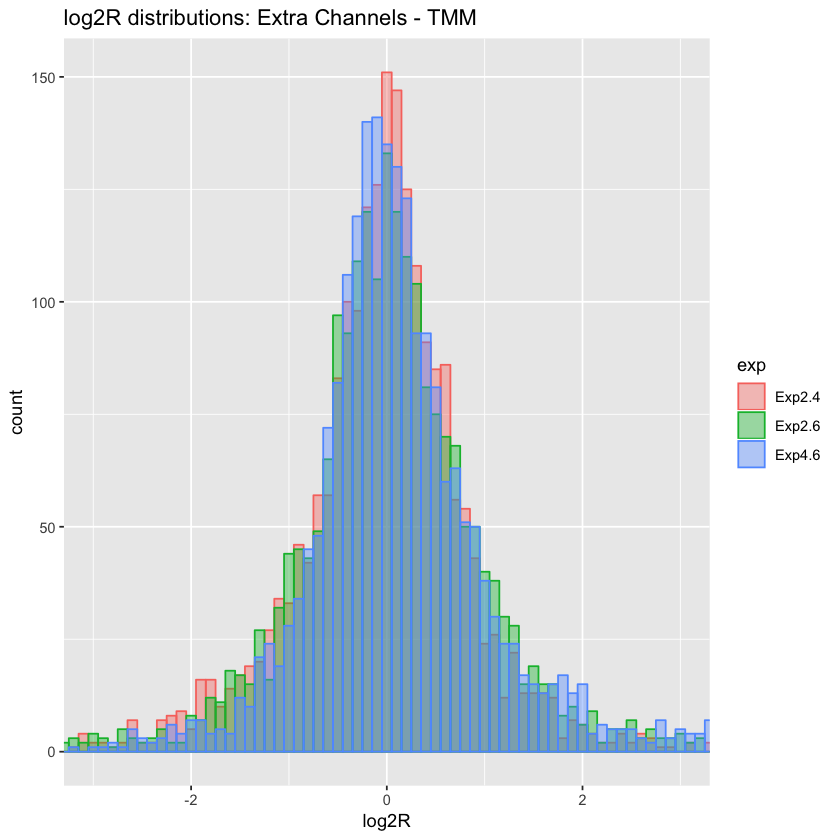

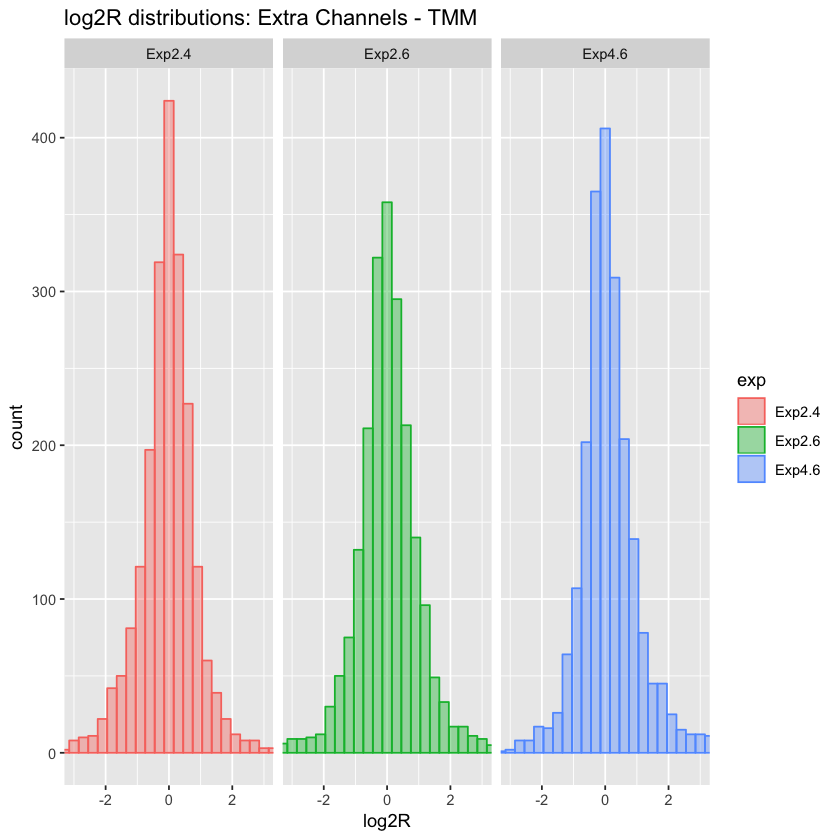

In [30]:
# form some log2 ratio vectors and pack into a data frame for TMM norm data
log2R_tmm <- data.frame(log2R = log2(pull(all_tmm[1]) / pull(all_tmm[4])), exp = "Exp2.4")
log2R_tmm <- rbind(log2R_tmm, data.frame(log2R = log2(pull(all_tmm[1]) / pull(all_tmm[7])), exp = "Exp2.6"))
log2R_tmm <- rbind(log2R_tmm, data.frame(log2R = log2(pull(all_tmm[4]) / pull(all_tmm[7])), exp = "Exp4.6"))

# get some of the base plot done
hplot <- ggplot(log2R_tmm, aes(x = log2R, color = exp, fill = exp)) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("log2R distributions: Extra Channels - TMM")

# look at combined data and separated by plex
hplot + geom_histogram(binwidth=0.1, alpha = 0.4, position = "identity")
hplot + geom_histogram(binwidth=0.3, alpha = 0.4, position = "identity") + facet_wrap(~exp)

### Log ratios greater than about 2 (4-fold) would be needed for non-IRS data
We picked TMM normalized data. The distribution of log2 ratios is getting near the baseline at values greater than 2 or less than -2. That is in the ballpark of 4-fold changes or larger before we might be able to detect any differential expression.

Make same plots after IRS.

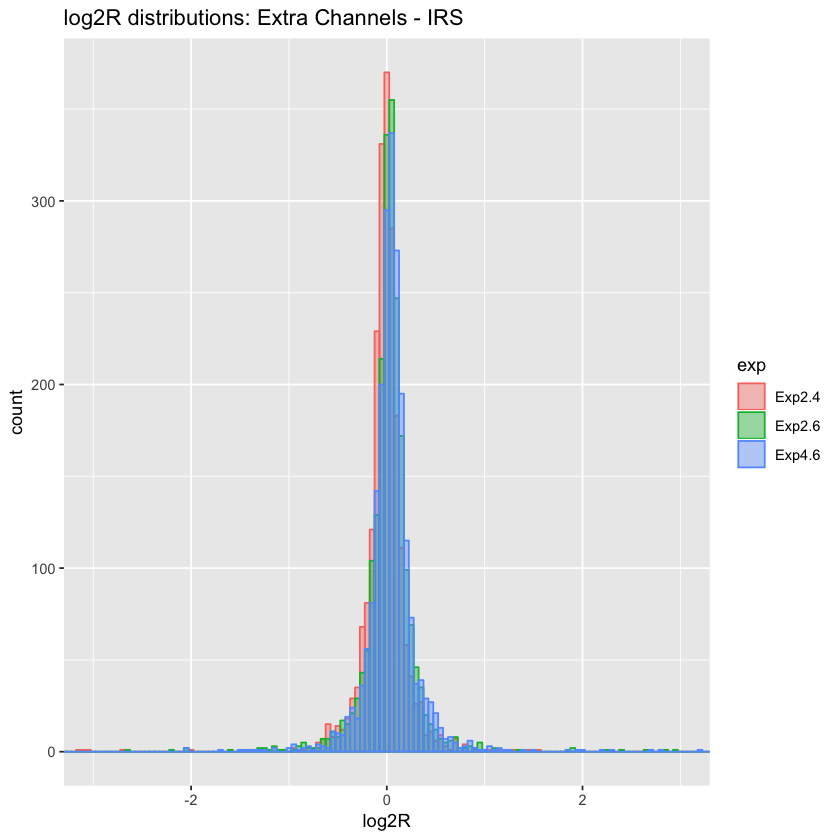

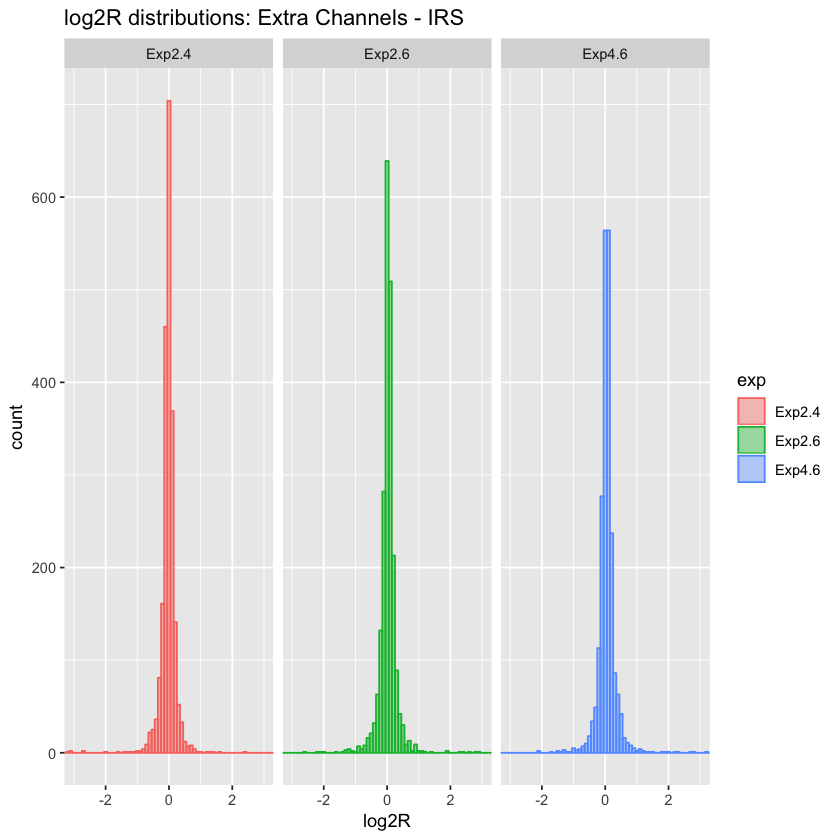

In [31]:
# make a log2 ratio data frame
log2R_irs <- data.frame(log2R = log2(pull(all_irs[1]) / pull(all_irs[4])), exp = "Exp2.4")
log2R_irs <- rbind(log2R_irs, data.frame(log2R = log2(pull(all_irs[1]) / pull(all_irs[7])), exp = "Exp2.6"))
log2R_irs <- rbind(log2R_irs, data.frame(log2R = log2(pull(all_irs[4]) / pull(all_irs[7])), exp = "Exp4.6"))

# some base parts of plot
hplot <- ggplot(log2R_irs, aes(x = log2R, color = exp, fill = exp)) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("log2R distributions: Extra Channels - IRS")

# set a few more parameters and show plots
hplot + geom_histogram(binwidth=0.05, alpha = 0.4, position = "identity")
hplot + geom_histogram(binwidth=0.1, alpha = 0.4, position = "identity") + facet_wrap(~exp)

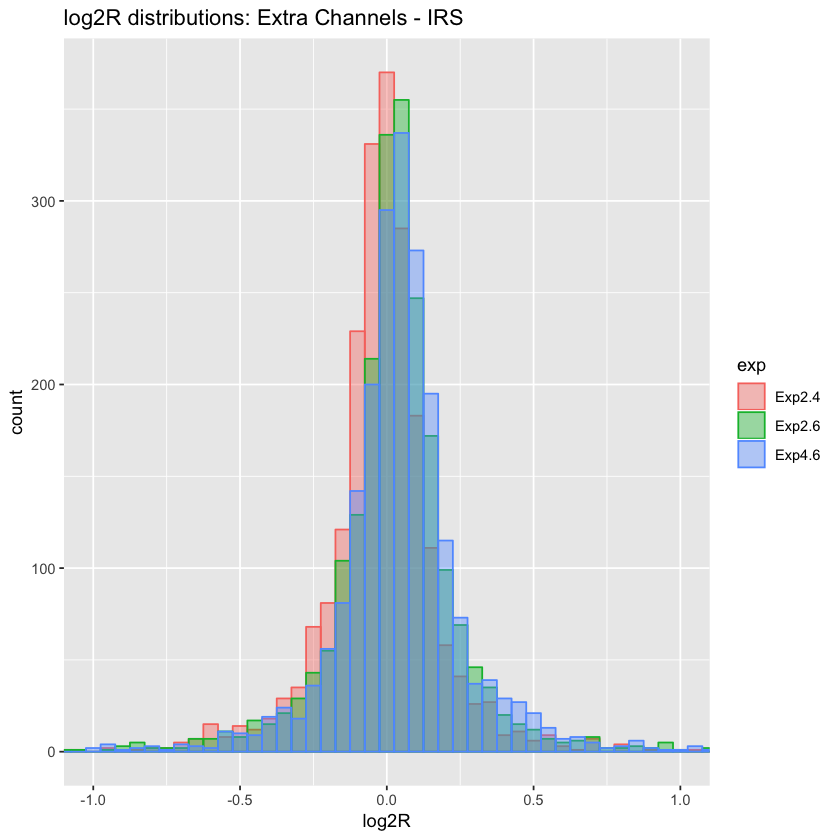

In [32]:
# expand the x-axis more
ggplot(log2R_irs, aes(x = log2R, color = exp, fill = exp)) +
  coord_cartesian(xlim = c(-1, 1)) +
  geom_histogram(binwidth=0.05, alpha = 0.4, position = "identity") +
  ggtitle("log2R distributions: Extra Channels - IRS")

### IRS normalized data has a much narrower distribution of log2 ratios
The base of the distribution for IRS data is getting near the base line at values of 0.5 or -0.5. That is the square root of 2 or about 1.4 fold changes for differential expression. The difference between 4-fold and 1.4-fold changes in expression studies is pretty gigantic. Data analysis without IRS will only be able to find differential expression if there are large expression differences.

---
# Conclusions

We were able to see how similar technical replicates were within single TMT plexes and between TMT plexes. Within TMT replicates are highly similar to each other and had highly correlated, very tight scatter plots. They had median protein CVs of 4.5% for this data. 

Technical replicate channels between different TMT plexes, with a wide range of conventional normalization methods, had much broader scatter plots and a median CV of almost 29%. 

IRS effectively removed random sampling effects between TMT plexes while preserving the typical within TMT data characteristics. Median CVs for the three extra channels after IRS were 5.5%, comparable to within TMT values. Scatter plots of extra reference channels from different plexes were poor without IRS and looked nearly as good as scatter plots of reference channels with the same plex after the IRS method.

---

</br>

## Batch effects versus normalizations

Batch effects are recognized in microarray and next generation sequencing experiments. This is a broad topic that we will not try and review here. Here is how it goes in practice. You do standard normalizations to remove common sources of variation from the data. You do a cluster or PCA analysis to see if your data separates into the expected biological conditions. If the data separates some other way that has some logical interpretation (reagent batch, dates of experiments, etc.), then there are batch effects. Batch effect corrections usually do more micro data adjustments than normalization methods. 

There are lots of methods to try to find and correct batch effects. I have used clustering views in other notebooks and in a [2018 ASMS poster](https://github.com/pwilmart/ASMS2018.git). Data without IRS will cluster by TMT plex. In some ways, TMT experiments involving multiple plexes look like a batch effects problem. Many batch correction methods rely on balanced study designs where the average of each plex serves as a proxy for the protein ruler provided by the internal reference channels. This can work for TMT experiments provided the balanced study design assumption is met. The [CONSTANd method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4974351/) is along these lines.

IRS has a couple of important differences from balanced study design batch correction. First, allocation of samples to plexes does not have to be balanced. Second, the data used for "batch" correction is mathematically independent from the biological sample data. This reduces confounding in the statistical modeling. 

There may be other data analysis methods that will work in this domain. I have not yet seen anything else that I think will work. However, please do not take my word for this. The point of this (long) notebook is that your data is perfectly capable of telling you how to analyze it. Notebooks and R make it possible to communicate with your data and make sure that your analysis reflects reality (do measurements of the same thing give the same values?).

In [33]:
# log session
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2        preprocessCore_1.44.0 robustbase_0.93-3    
 [4] edgeR_3.24.3          limma_3.38.3          psych_1.8.10         
 [7] forcats_0.3.0         stringr_1.3.1         dplyr_0.7.8          
[10] purrr_0.2.5           readr_1.3.1           tidyr_0.8.2          
[13] tibble_2.0.0          ggplot2_3.1.0         tidyverse_1.2.1      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     locfit_1.5-9.1   tidyselect_0.2.5 repr_0.19.1     
 [5] haven_2.0.0      lattice_0.